## Wprowadzenie

Zadania będą polegały na implementacji różnych wariantów algorytmu Q-Learning dla dwóch środowisk z biblioteki ~~OpenAI Gym~~ Gymnasium (https://gymnasium.farama.org/): `CartPole` i `LunarLander`.

#### Uwaga: Możesz dowolnie modyfikować elementy tego notebooka (wstawiać komórki i zmieniać kod) o ile nie napisano gdzieś inaczej.

In [ ]:
# Zainstaluj bibliotekę Gymnasium i PyTorch
!pip install "gymnasium[box2d]==0.28" torch matplotlib numpy

### Środowisko `CartPole` i `LunarLander`

Poniższy kod demonstruje działanie środowiska `CartPole` (https://gymnasium.farama.org/environments/classic_control/cart_pole/) i `LunarLander` (https://gymnasium.farama.org/environments/box2d/lunar_lander/).

In [ ]:
# Zobacz jak działają środowiska na przykładzie 100 kroków
import gymnasium as gym

#env = gym.make("CartPole-v1", render_mode="human")
env = gym.make("LunarLander-v2", render_mode="human")
observation, info = env.reset()

for _ in range(100):
  # Pokaż obraz z środowiska
  env.render()

  # Wybierz losową akcję z przestrzeni akcji
  action = env.action_space.sample()

  # Wykonaj akcję i otrzymaj informację o kolejnym stanie, nagrodzie
  # i czy środowisko zostało zakończone.
  # Zobacz https://gymnasium.farama.org/api/env/#gymnasium.Env.step
  # by sprawdzić opis wszystkich zwracanych wartości.
  observation, reward, term, trunc, _ = env.step(action)
  done = term or trunc

  if done:
    observation, info = env.reset()
env.close()

In [ ]:
# Zobacz jakim typem są obserwacje (reprezentacja stanu) oraz jaka jest przestrzeń akcji:
print("Przestrzeń stanów:", env.observation_space)
print("Rozmiar wektora reprezntującego stany:", env.observation_space.shape)
print("Ostatnia obserwacja:", type(observation), observation)
print("Przestrzeń akcji:", env.action_space)
print("Ilość możliwych akcji:", env.action_space.n)

### Interface agenta

Wszystkie implementacje będą w oparciu o klasę `Agent` przedstawioną poniżej. Powinna ona implementować dwie metody:
 1. `process_transition`, która będzie wykorzystywana tylko podczas uczenia, by przekazać do agenta krotkę zawierającą obserwacje, podjętą akcję, nagrodę i następujący stan oraz informację czy jest on terminalny.
 2. `get_action` która na podstawie obserwacji zwraca akcję, dodatkowy argument informuję Agenta czy jest w aktualnie podczas uczenia czy ewaluacji.

Poniżej znajdziesz też funkcję `run_agent_in_env`, która korzysta z opisanego wyżej obiektu agenta w celu jego uczenia lub ewaluacji (podobną będziemy używać my podczas sprawdzania wszych rozwiązań). Możecie ją modyfikować jeśli widzicie taką potrzebę. Dopisaliśmy do tej funkcji rysowanie wykresu nagród z minionych epizodów, który uaktualnia się co ich zadaną liczbę.

In [ ]:
import gymnasium as gym


class Agent:
  def __init__(self, env):
    self.observation_space = env.observation_space
    self.action_space = env.action_space

  def process_transition(self, observation, action, reward, next_observation, done):
    raise NotImplementedError()

  def get_action(self, observation, learning):
    raise NotImplementedError()

In [ ]:
import pandas as pd
import matplotlib.pylab as plt
from IPython import display
from tqdm.notebook import tqdm
%matplotlib inline

def plot_rewards(rewards):
  plt.figure(figsize=(14, 6))
  # good amount for plotting
  plt.plot(rewards)
  plt.plot([0, len(rewards)], [0, 0], 'k--')
  plt.plot([0, len(rewards)], [500, 500], 'k--')
  # min max across all time
  plt.plot(pd.Series(rewards).expanding().min())
  plt.plot(pd.Series(rewards).expanding().max())
  # 50 % percentile
  # moving average of every 250 episodes
  plt.plot(pd.Series(rewards).rolling(250).quantile(0.5))

  display.display(plt.gcf())
  # display.clear_output(wait=True)


def run_agent_in_env(env, agent, episodes, learning=False, plot=False, plot_interval=1000):
  rewards = []
  for episode in tqdm(range(episodes)):
    state, _ = env.reset()
    total_reward = 0
    is_finished = False

    while not is_finished:
      action = agent.get_action(state, learning)

      next_state, reward, is_terminated, is_truncated, _ = env.step(action)
      is_finished = is_terminated or is_truncated
      total_reward += reward

      if learning: agent.process_transition(state, action, reward, next_state, is_finished)

      state = next_state
    rewards.append(total_reward)

    # Wyświetl na wykresie nagrody otrzymane po kolei w epizodach
    if plot and episode > 0 and episode % plot_interval == 0:
      plot_rewards(rewards)
  return rewards

In [ ]:
# Demonstracja na przykładzie losowego agenta
env = gym.make("CartPole-v1")


class RandomAgent(Agent):
  def __init__(self, env):
    super().__init__(env)

  def process_transition(self, observation, action, reward, next_observation, done):
    pass

  def get_action(self, observation, learning):
    return self.action_space.sample()


random_agent = RandomAgent(env)
rewards = run_agent_in_env(env, random_agent, 10000, plot=True, plot_interval=500)

## Zad. 3.1 - Tabularyczny Q-Learning (5 pkt.)

W komórkach poniżej zaimplementuj prosty tabularyczny Q-Learning dla środowiska `CartPole`, korzystający podczas uczenia się z polityki epsilon-greedy. Ponieważ środowisko `CartPole` ma ciągłą przestrzeń stanów, musisz dokonać odpowiedniej dyskretyzacji stanów.

Odpowiedź na pytanie: dlaczego po osiągnięciu dobrych wyników obserwujemy spadek jakości? Czy możemy temu jakoś zaradzić?

Uwagi:
- Dobra polityka dająca średni wynik powyżej 200, środowisko ma limit na 500 iteracji. Polityka dająca średni wynik blisko 500 jest więc bardzo dobra.
- Uczenie nie powinno trwać więcej niż 10-15 minut na CPU.
- Postaraj się dobrać i ustawić w `__init__` takie parametry by Twój Agent uczył się i działał jak najlepiej. Są one pod Twoją kontrolą w klasie, więc możesz je odpowiednio kontrolować w trakcie uczenia.


#### Uwaga: nie zmieniaj nazwy klasy `TabularQLearningAgent`, ani pozycyjnych (tych bez wartości domyślnych) argumentów jej metod, możesz dopisywać argumenty z wartościami domyślnymi oraz oczywiście pomocnicze metody do klasy. Pomocnicze metody powinny być w tej samej komórce (sprawdzarka wyciągnie ze zgłoszonego notebooka wyłącznie komórkę z klasą `TabularQLearningAgent`, kod w innych komórkach nie będzie widziany przez sprawdzarkę!). Nie dopisuj do komórki z klasą innego kodu.

Odpowiedzi:
1. Po osiągnięciu dobrych wyników obserwujemy spadek jakości. Ponieważ agent nie potrafi w środowisku odróżnić odcięcia po wygranej od terminacji rozgrywki. Można temu zaradzić poprzez zaprzestanie nauce po osiągnięciu odpowiedniego progu jakości rozwiązania. Lub zastosować metodę zapamiętywania najlepszej tablicy jakości.

In [78]:
from collections import deque
from copy import deepcopy
import numpy as np
import random
from gymnasium import Env


class TabularQLearningAgent(Agent):
  def __init__(self, env: Env):
    super().__init__(env)
    self.gamma = 0.99
    self.epsilon = 0.5
    self.eps_decay = 0.99
    self.epsilon_min = 0.01
    self.learning_rate = 0.25
    self.bins = np.array([2, 8, 12, 8])
    # based on https://gymnasium.farama.org/environments/classic_control/cart_pole/ info
    self.bounds = np.array([4, 4, 0.4, 4])
    self.limits = np.array([2, 2, 0.2, 2])

    self.buckets = [
      np.linspace(-limit, limit, bin)
      for (limit, bin) in zip(self.limits, self.bins)
    ]

    self.quality = np.zeros((*self.bins, self.action_space.n))

  def update_epsilon(self):
    self.epsilon = max(self.epsilon_min, self.epsilon * self.eps_decay)

  def train(self, experience):
    state, action, reward, next_state, done = experience

    prediction = self.quality[state][action]
    if done:
      target = reward
    else:
      target = reward + self.gamma * np.max(self.quality[next_state])

    self.quality[state][action] -= self.learning_rate * (prediction - target)

  def process_transition(self, observation, action, reward, next_observation, done):
    state = self.discretize(observation)
    next_state = self.discretize(next_observation)

    self.train((state, action, reward, next_state, done))

    if not done: return
    self.update_epsilon()

  def get_action(self, observation, learning):
    if learning and random.random() < self.epsilon:
      return self.action_space.sample()
    return np.argmax(self.quality[self.discretize(observation)])

  def discretize(self, state):
    def indexer(index, value):
      (min, max) = 0, self.bins[index] - 1
      (limit, bound) = self.limits[index], self.bounds[index]
      if value <= -limit: return min
      if value >= limit: return max

      offset = max * limit / bound
      scale = max / bound
      return int(np.round(scale * value - offset))

    return tuple(map(indexer, range(len(state)), state))


  0%|          | 0/10000 [00:00<?, ?it/s]

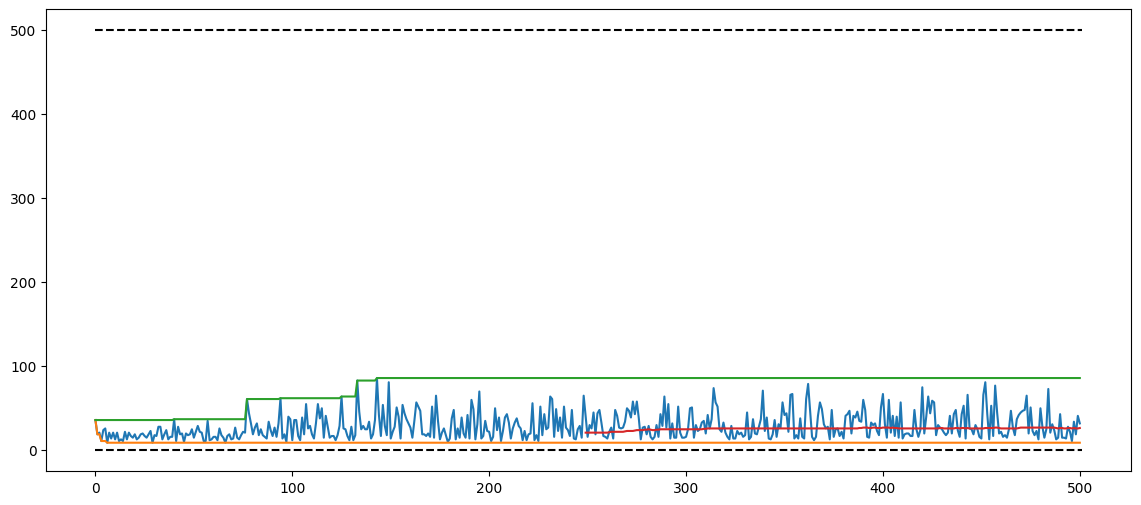

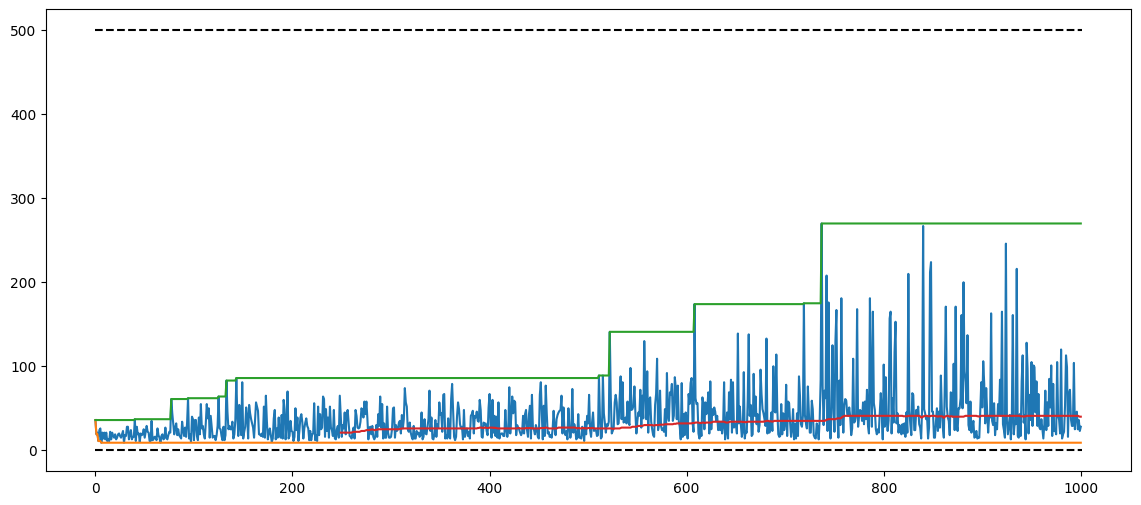

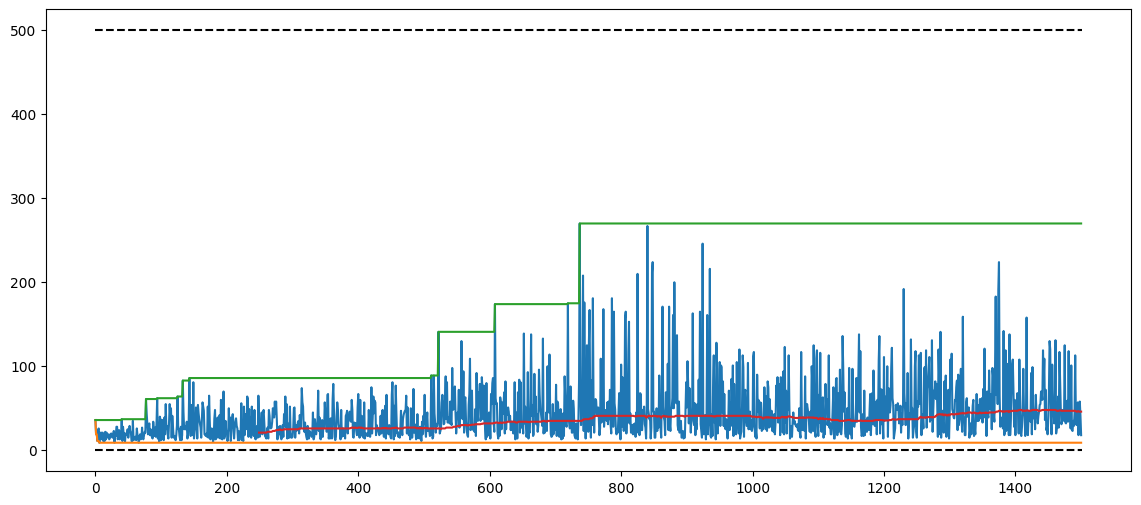

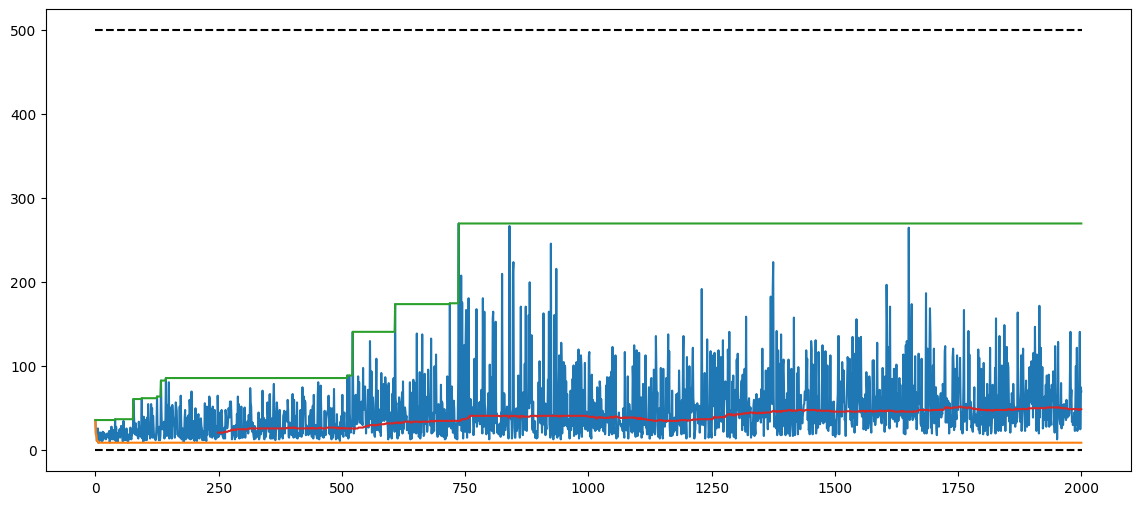

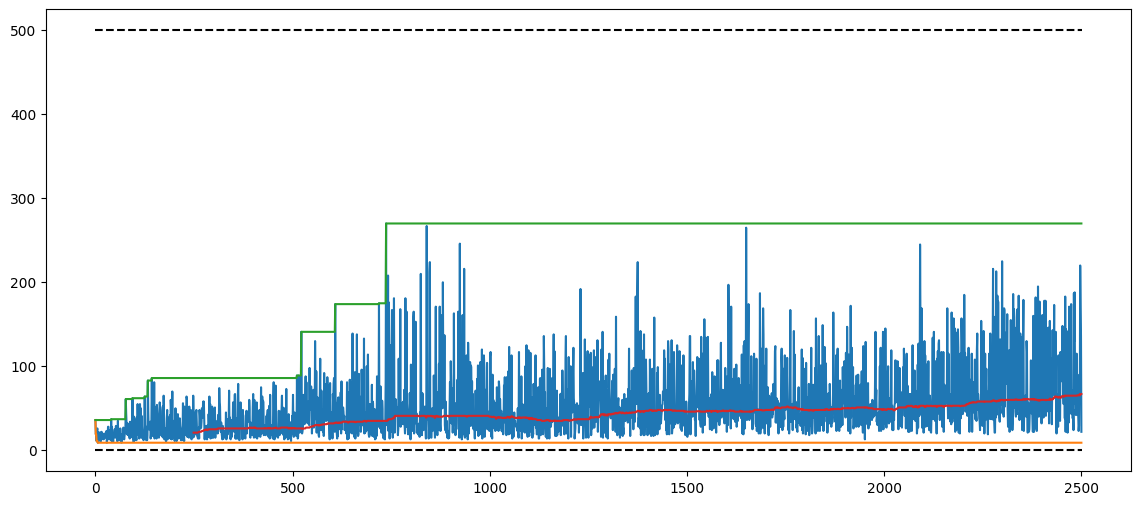

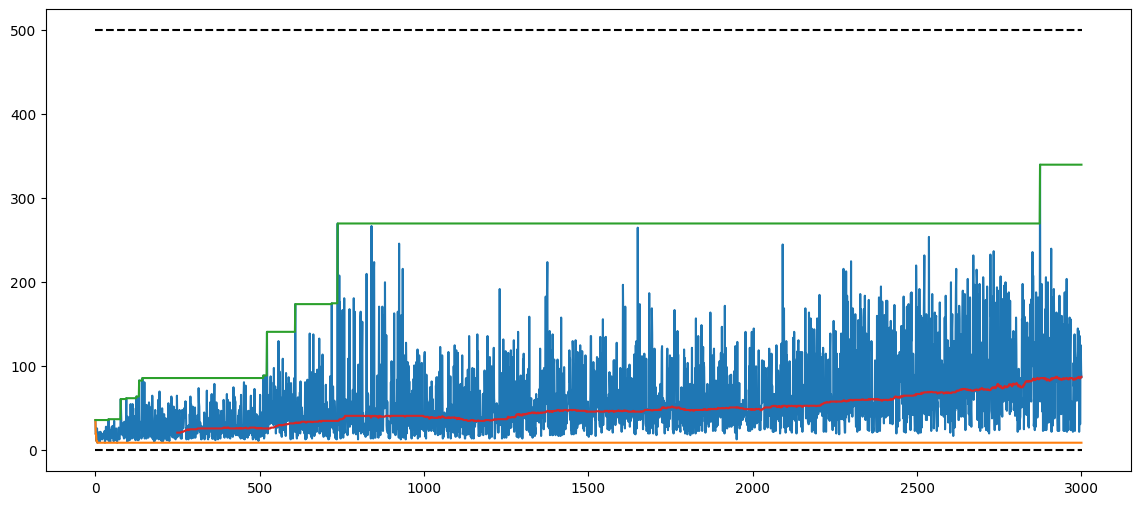

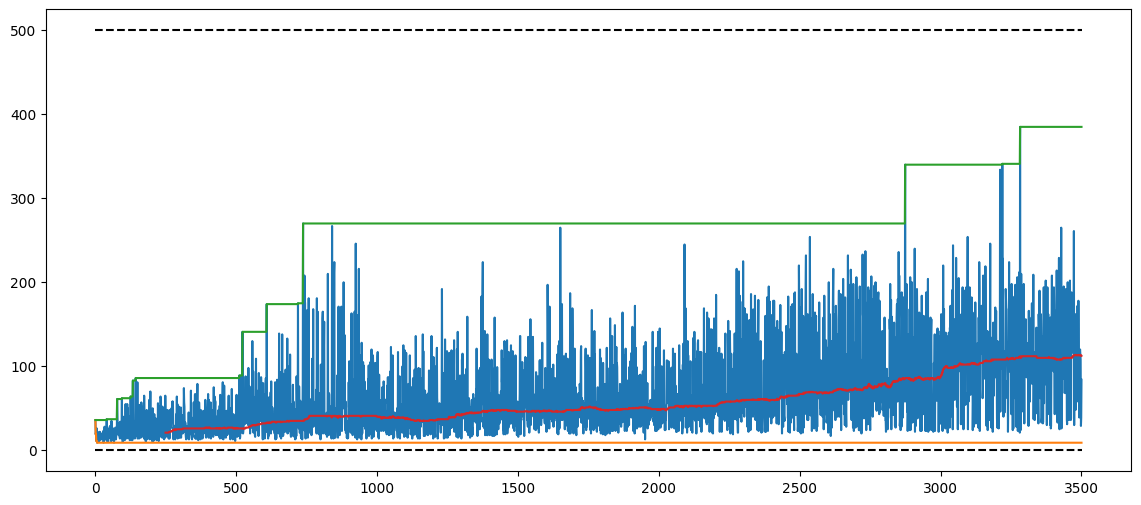

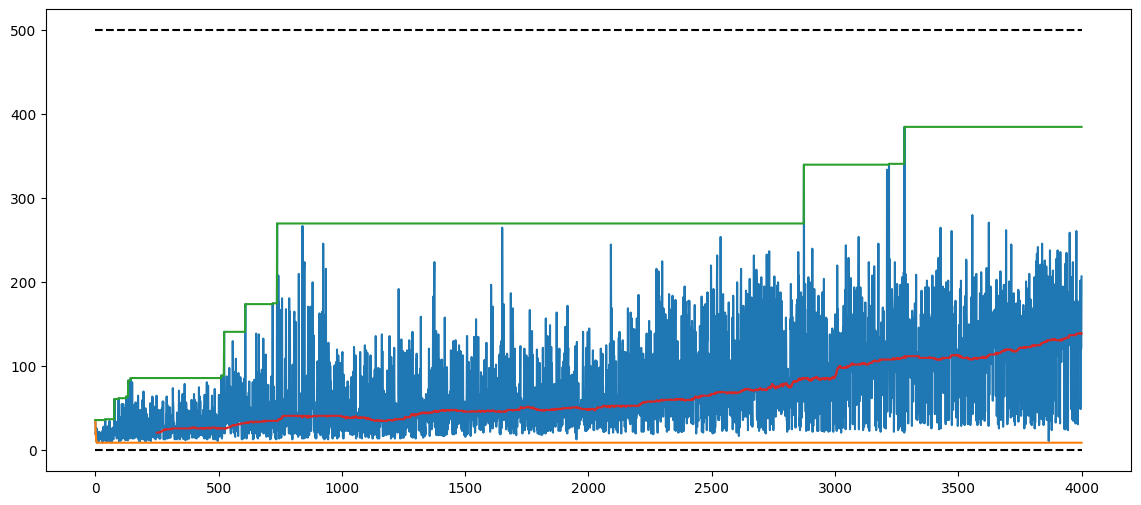

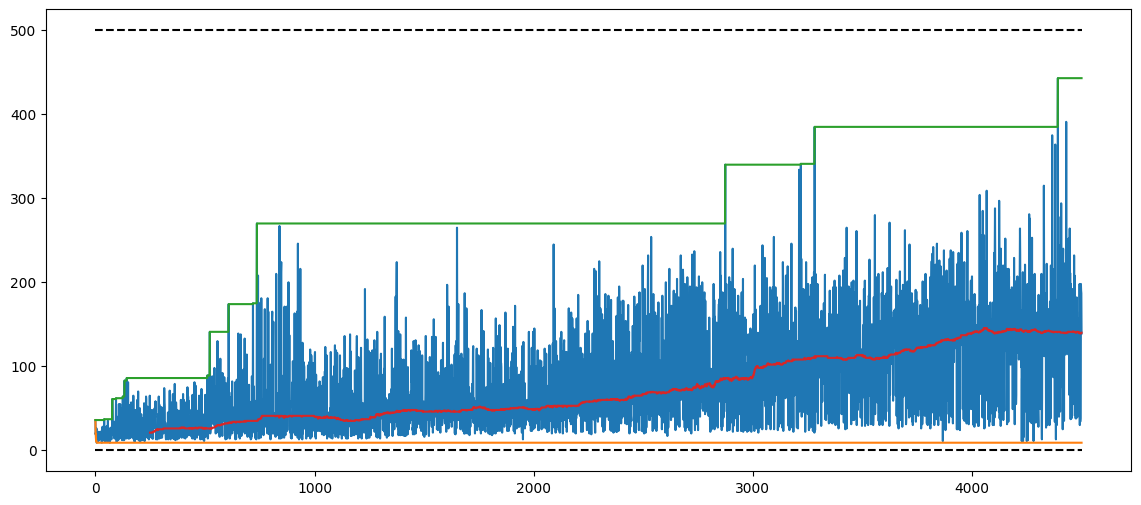

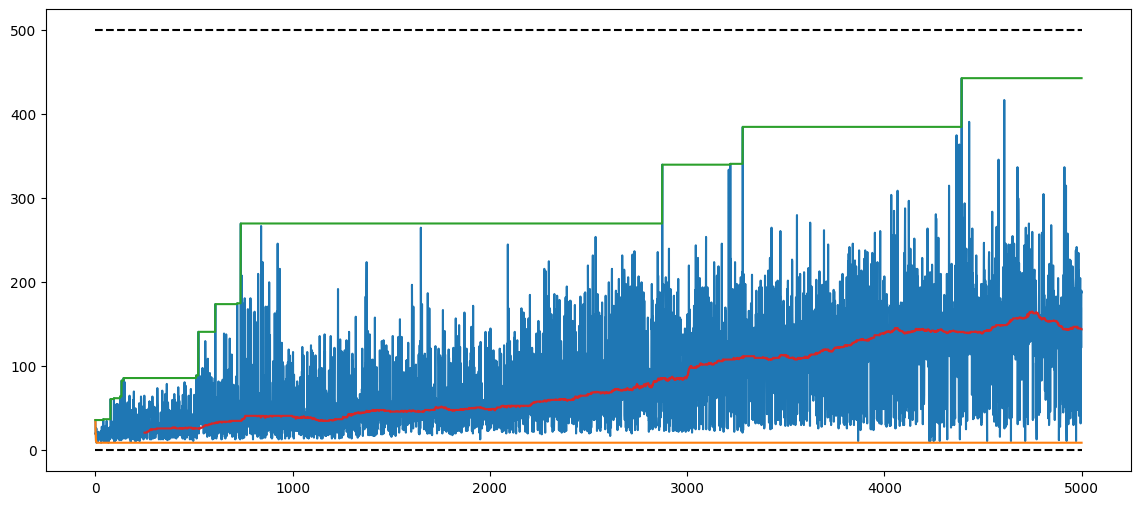

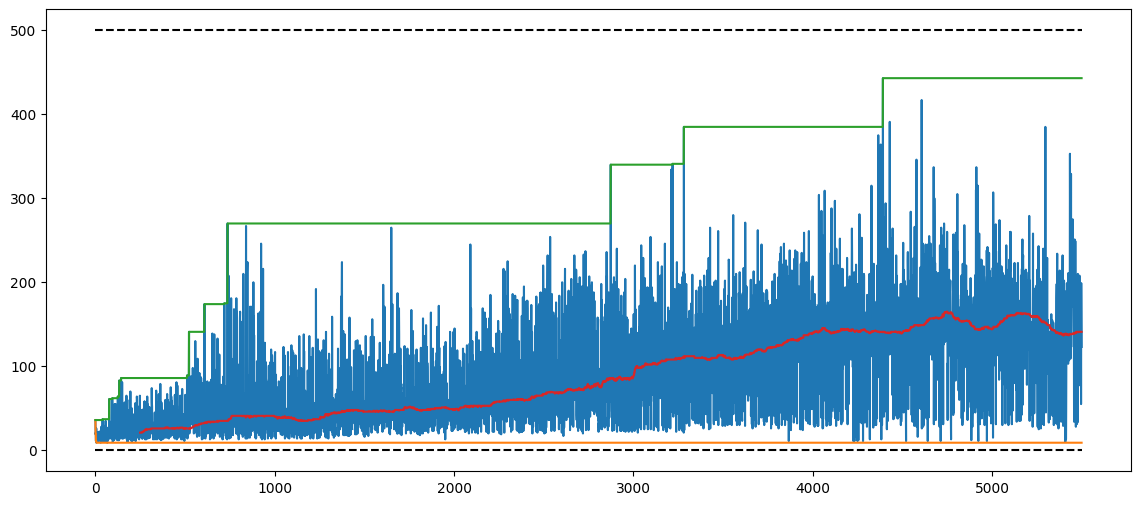

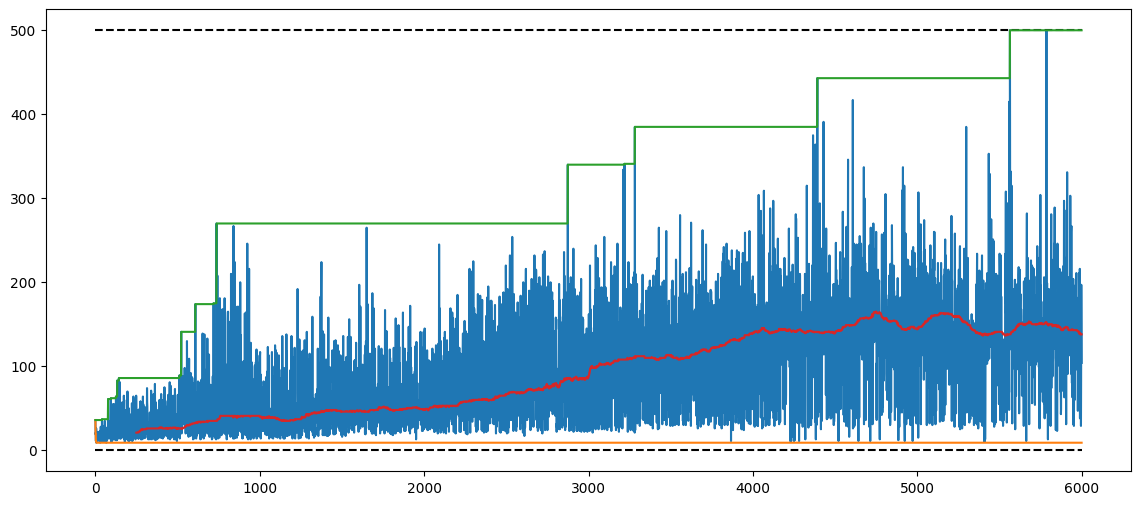

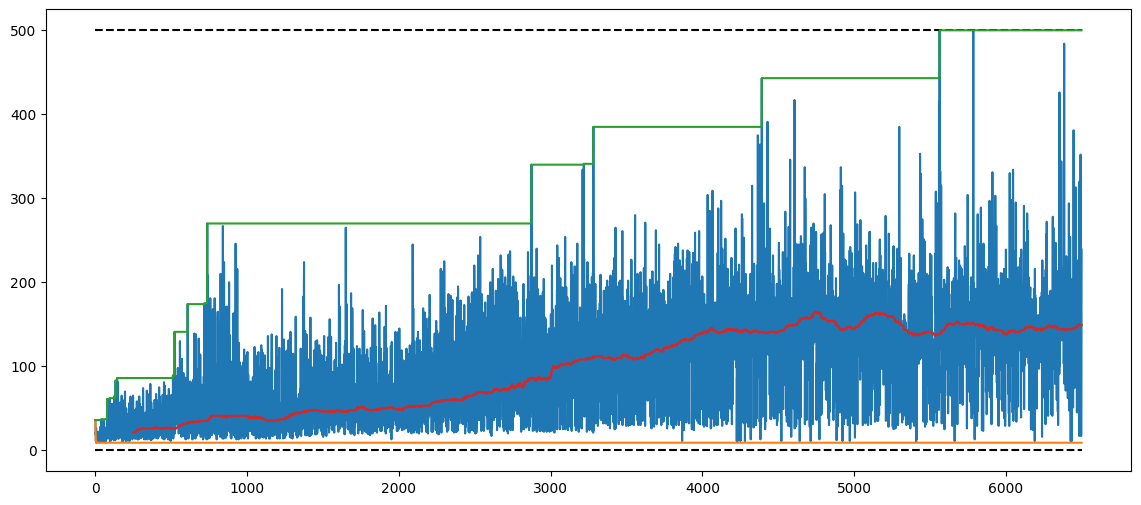

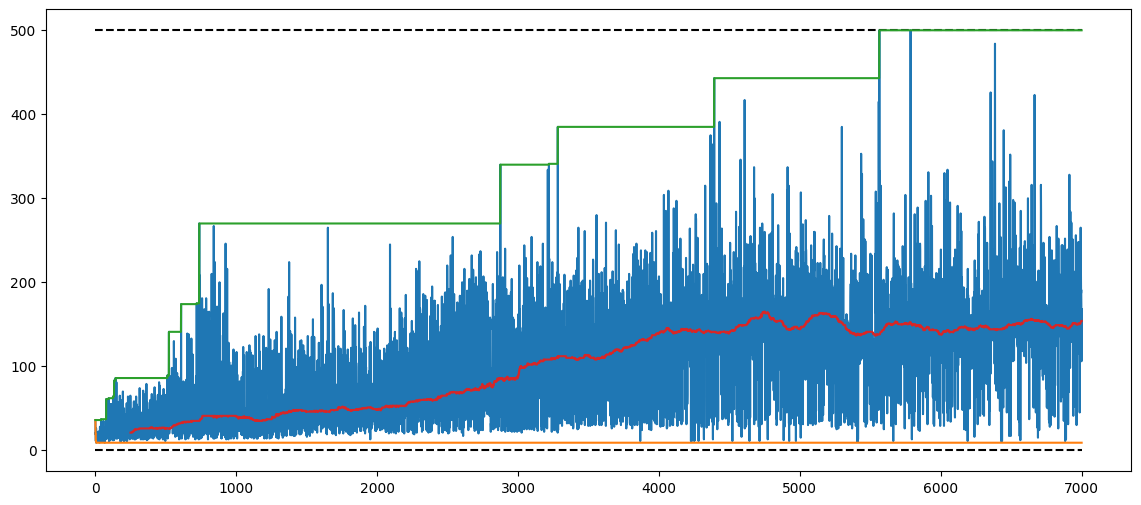

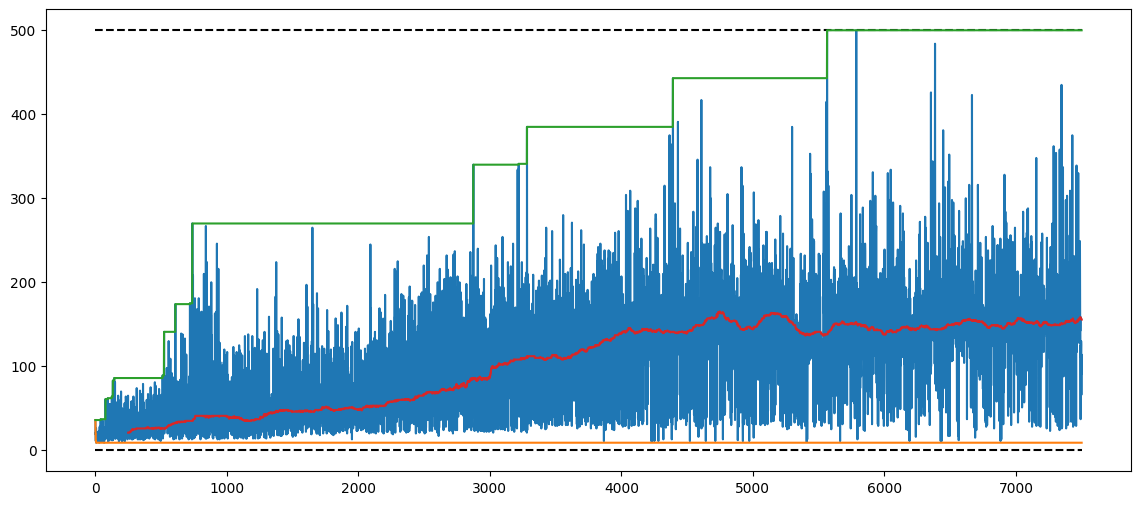

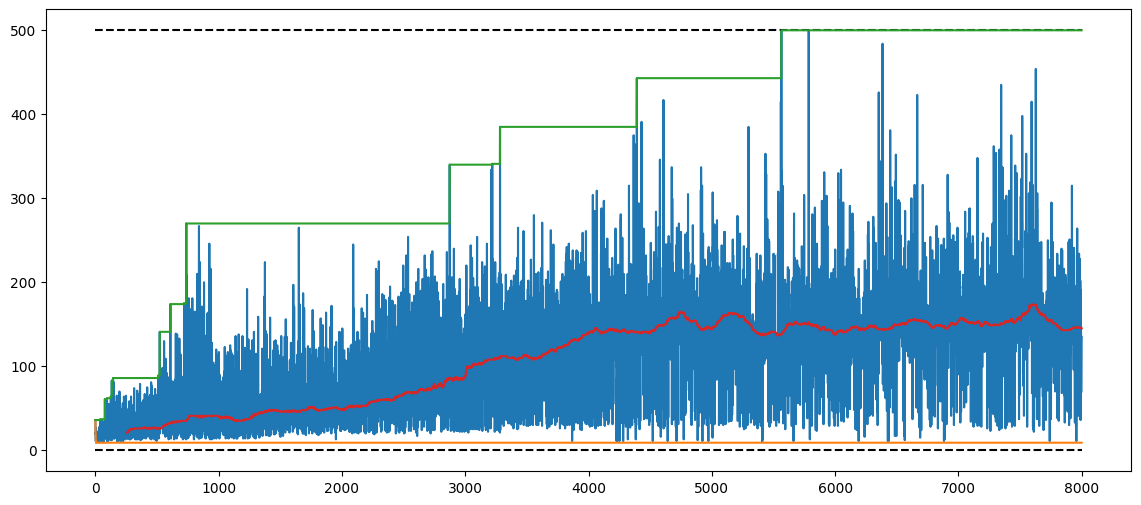

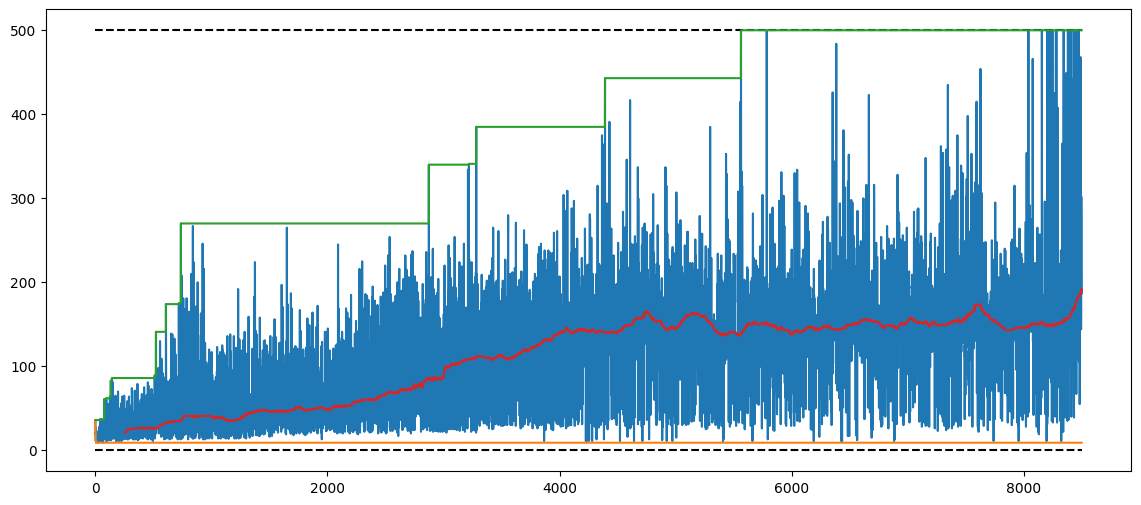

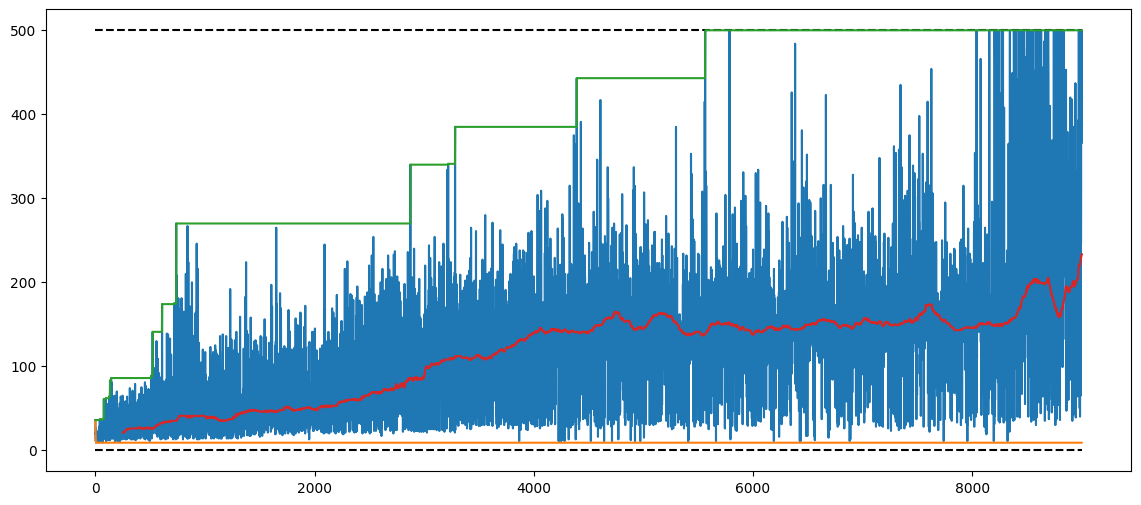

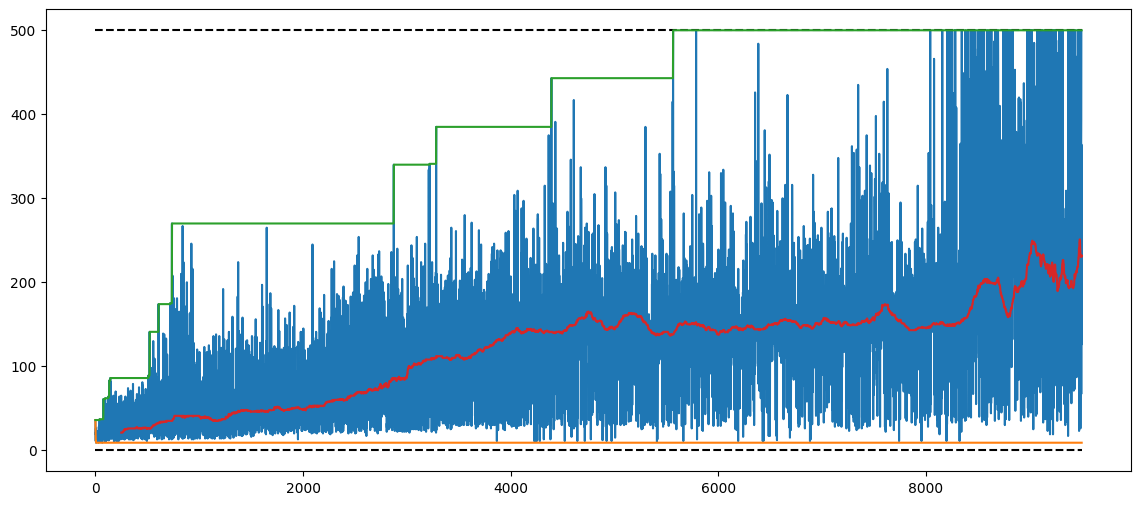

Reward: 137.0993


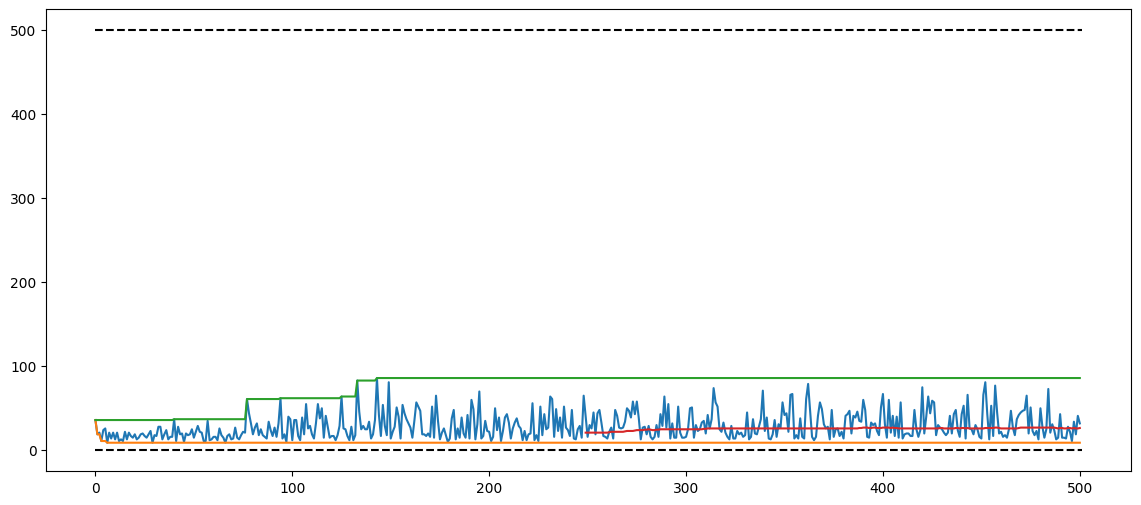

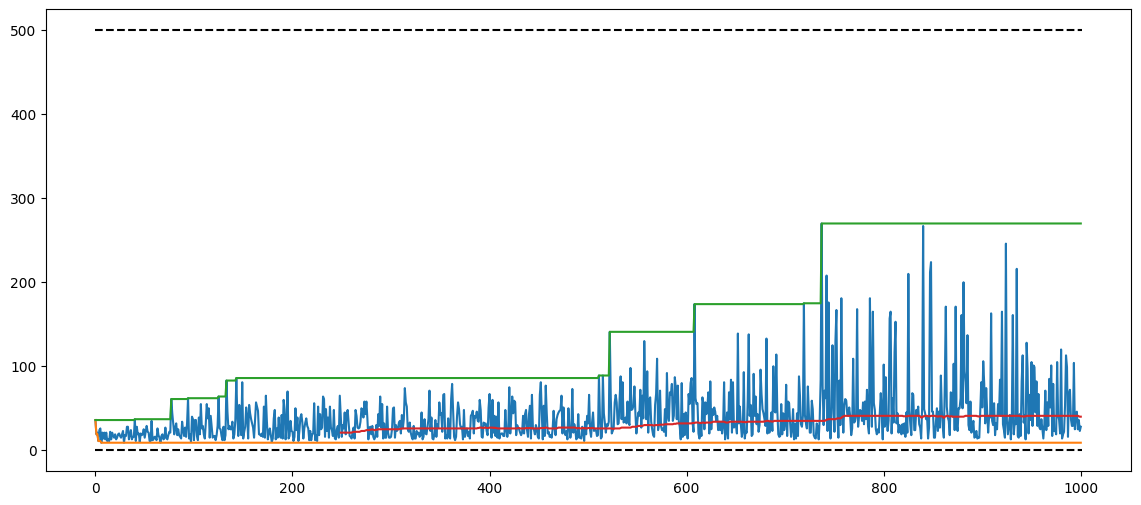

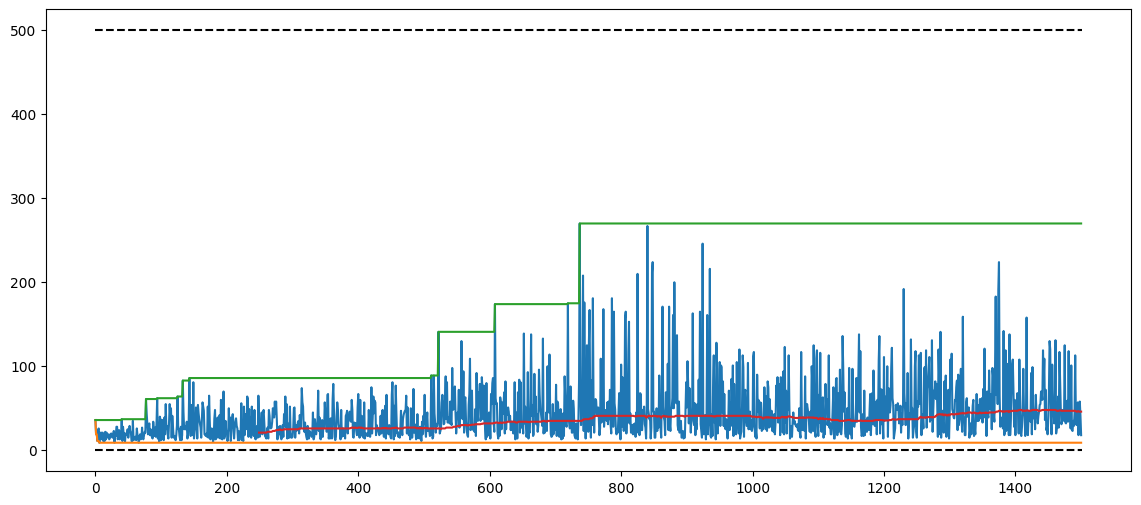

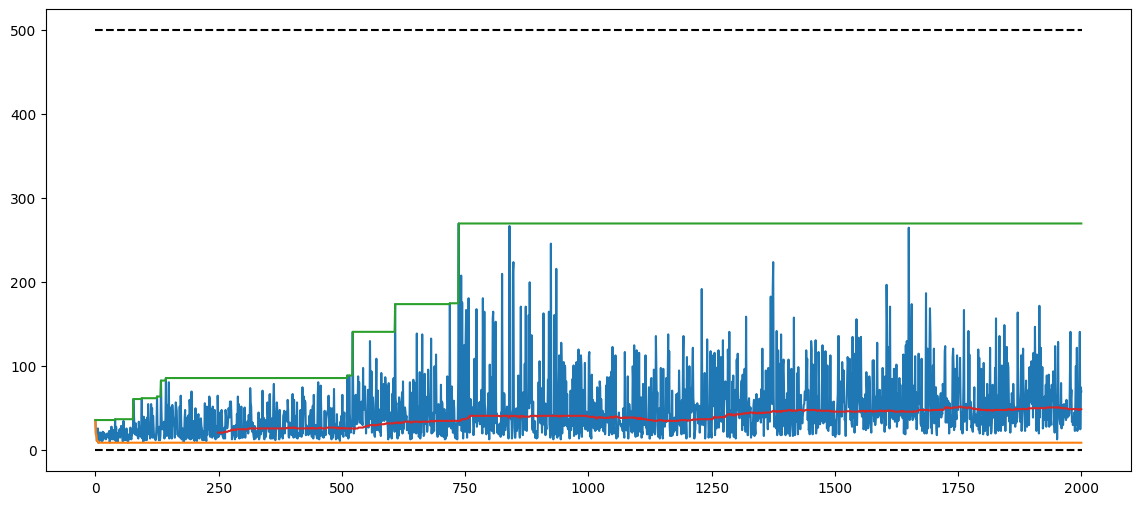

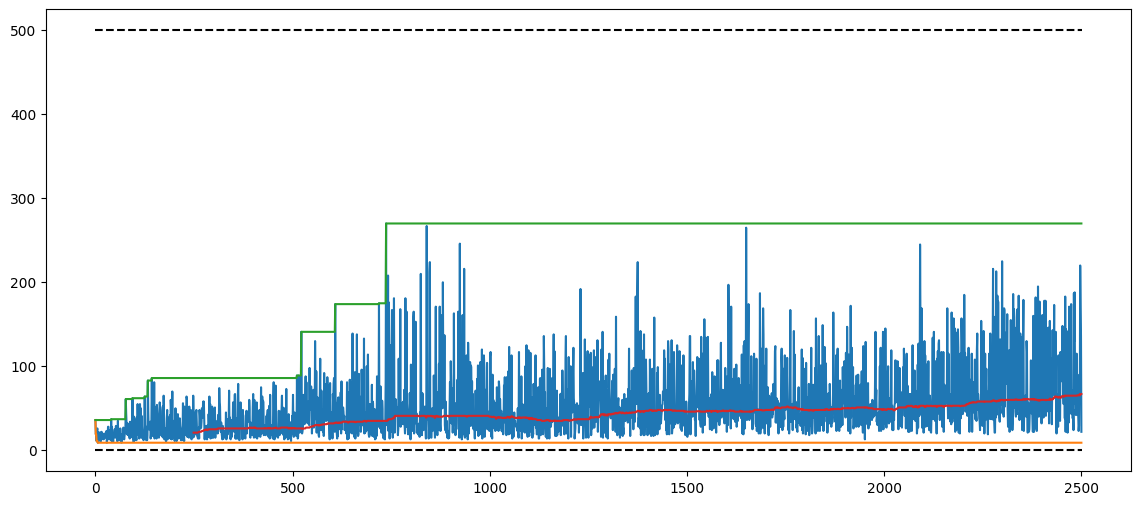

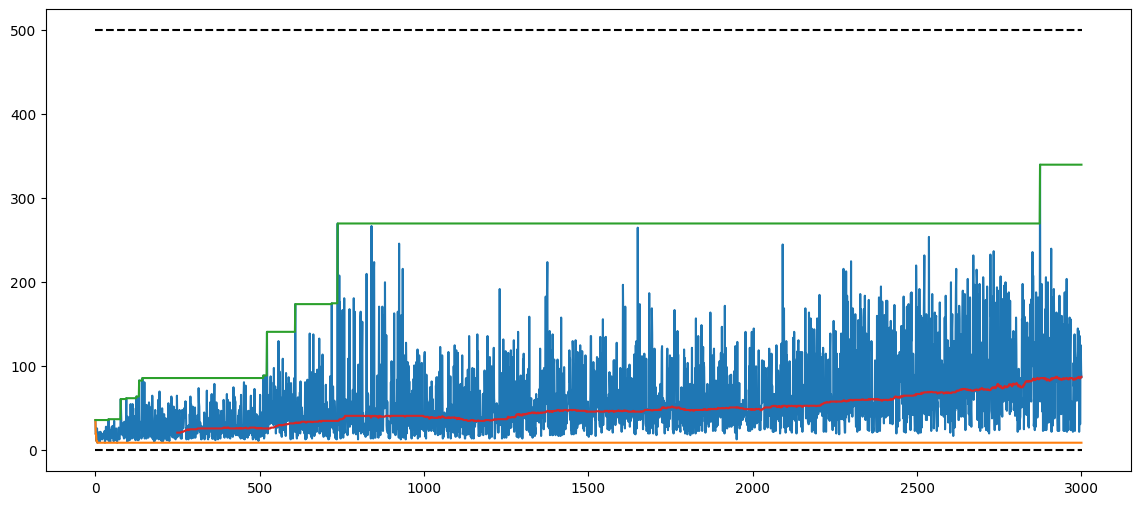

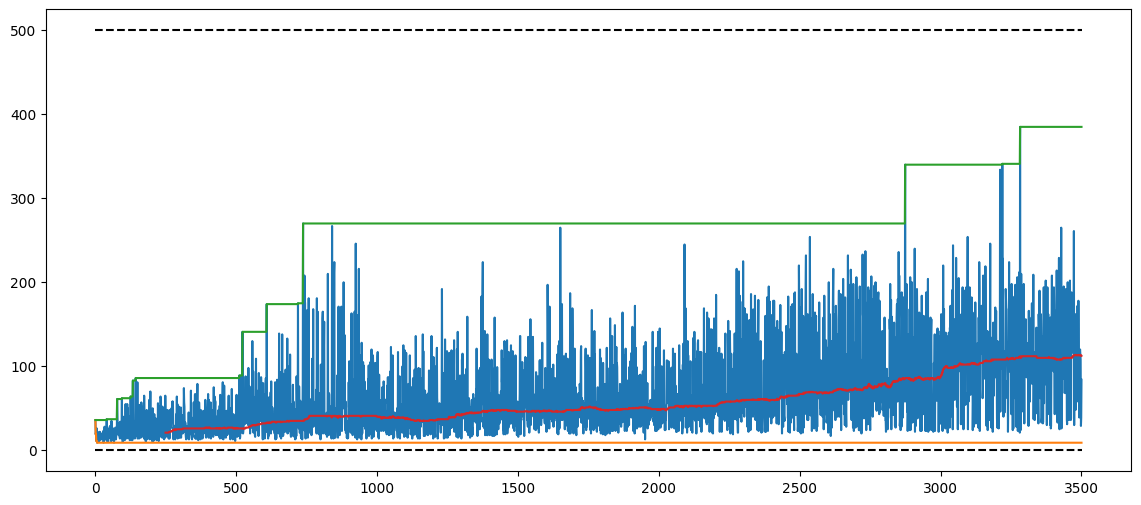

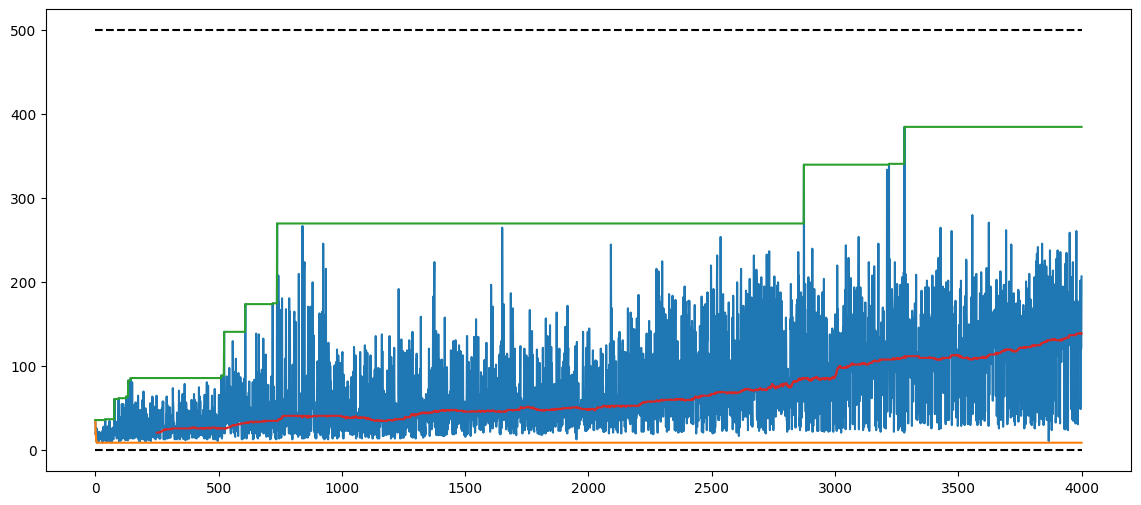

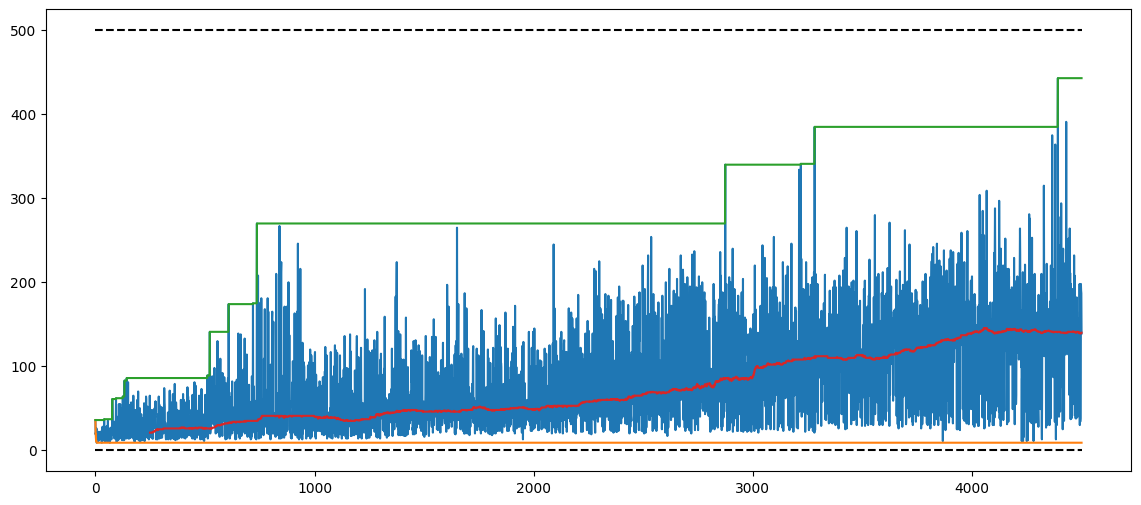

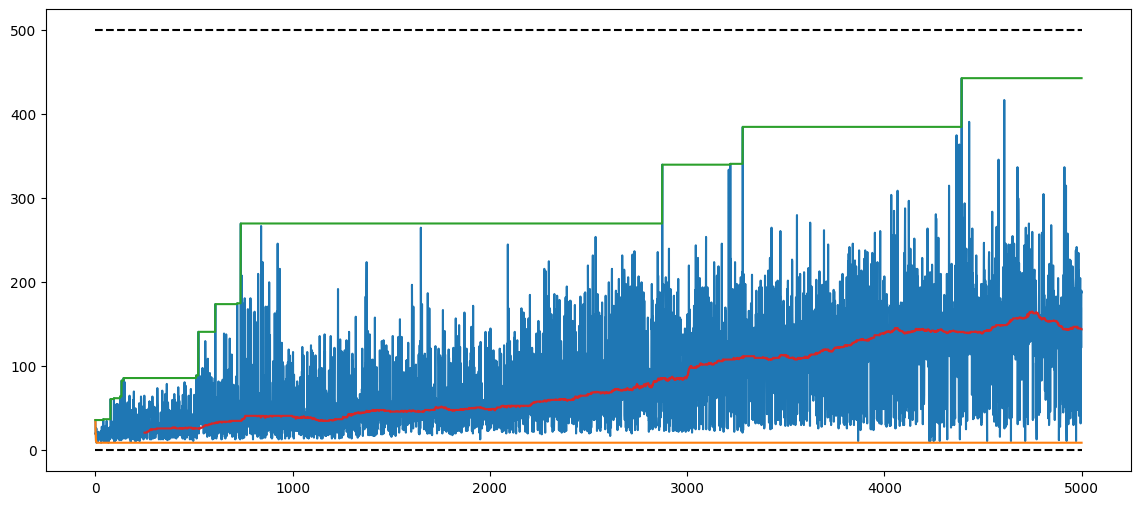

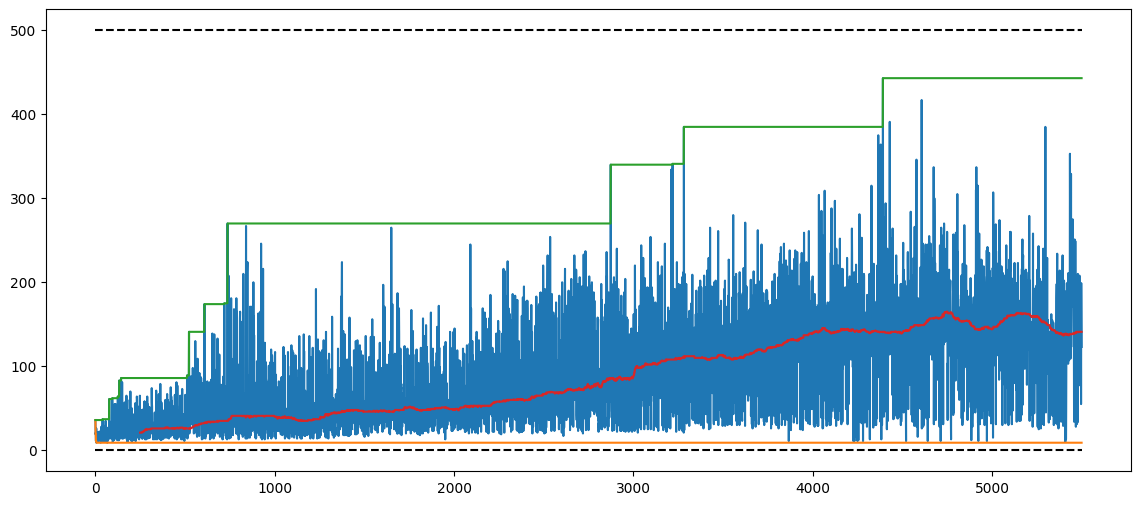

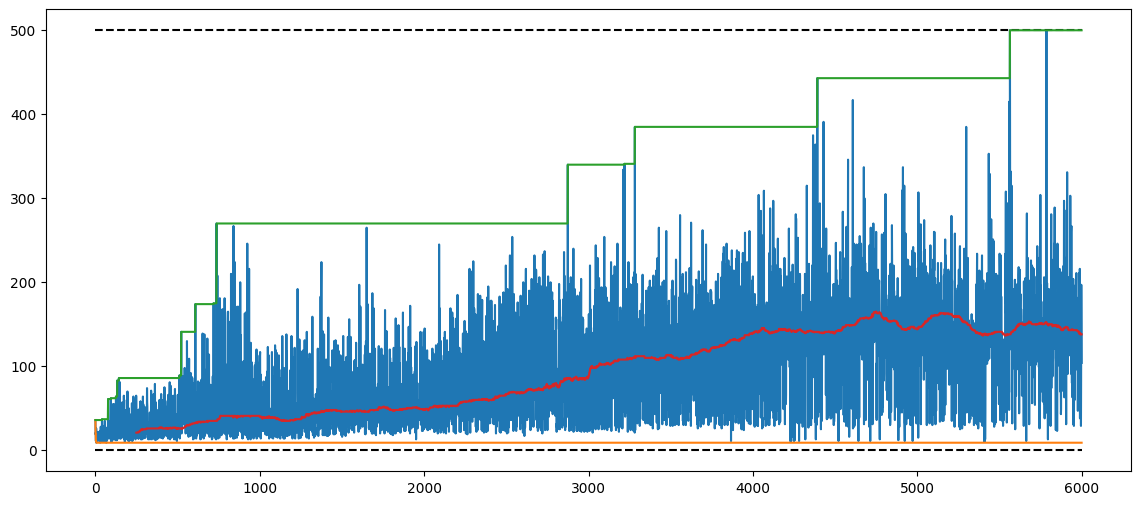

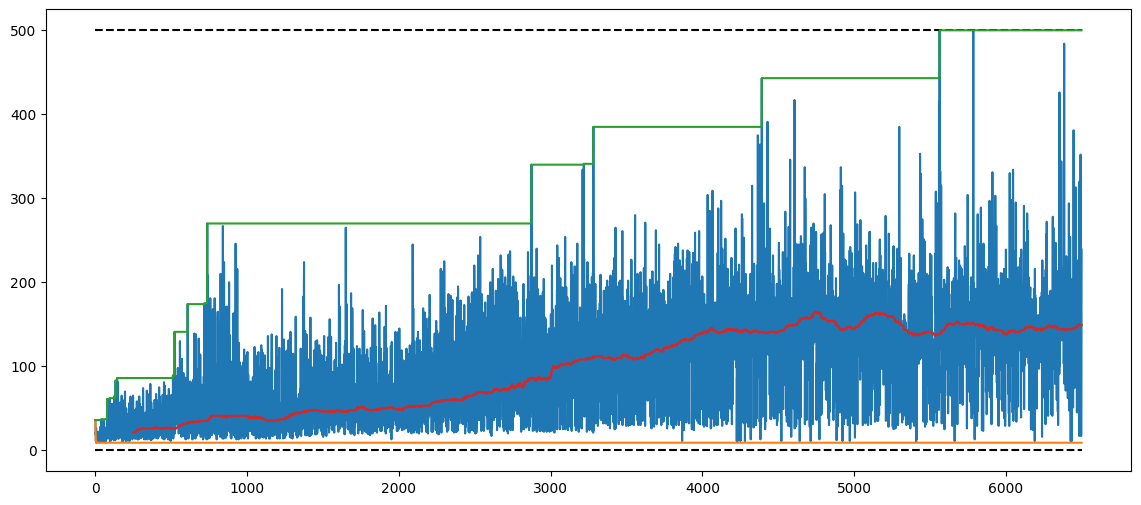

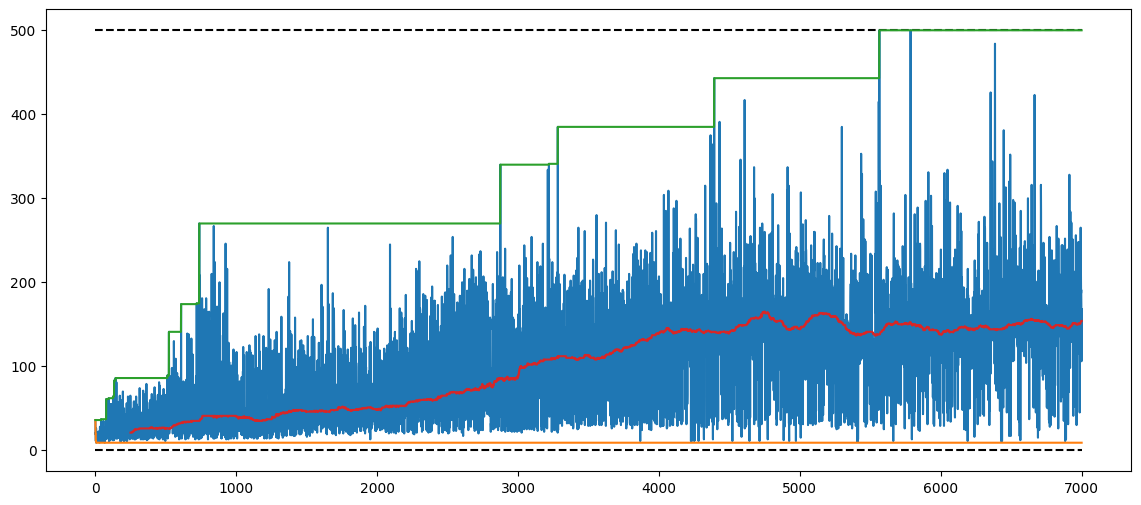

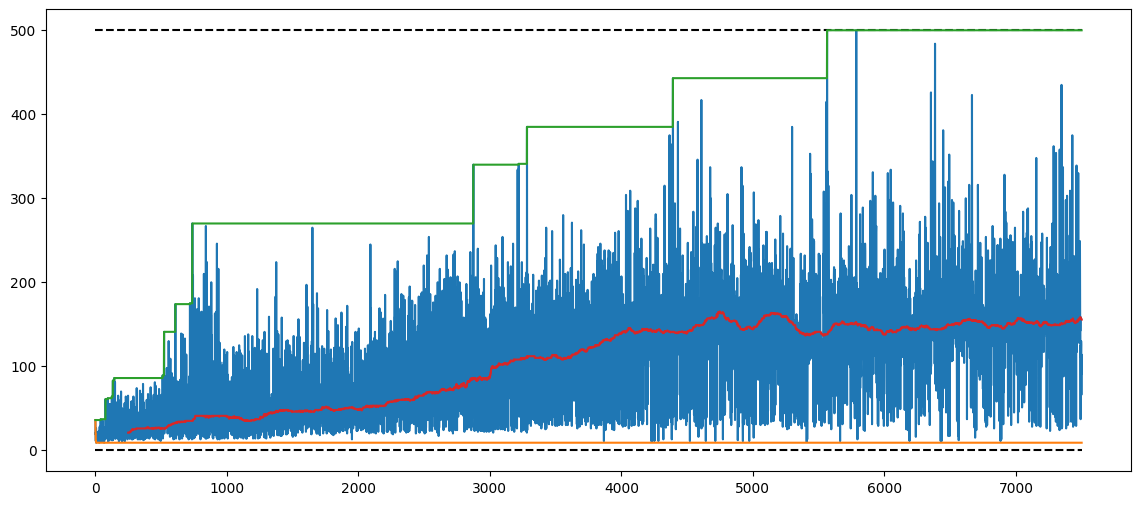

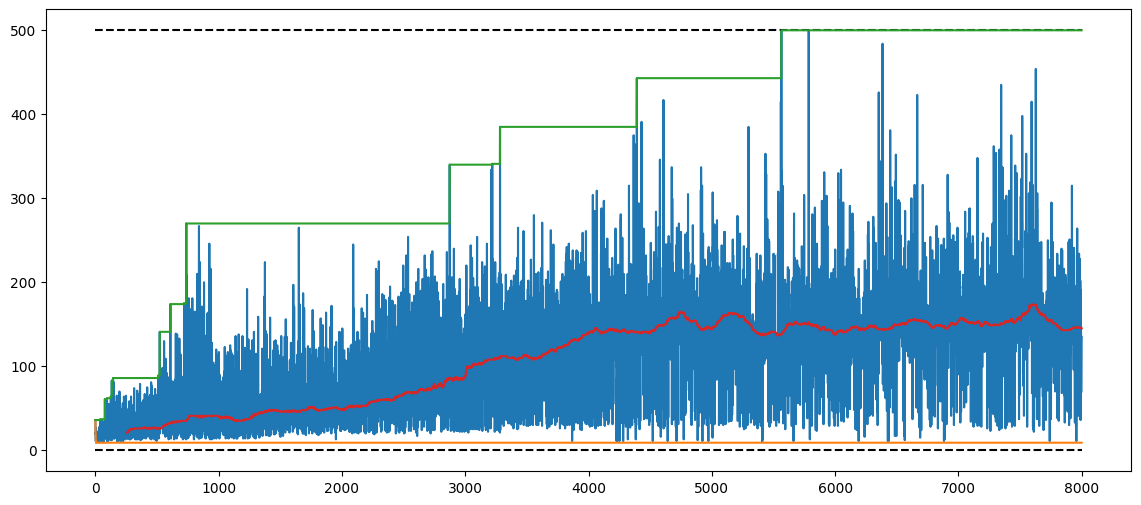

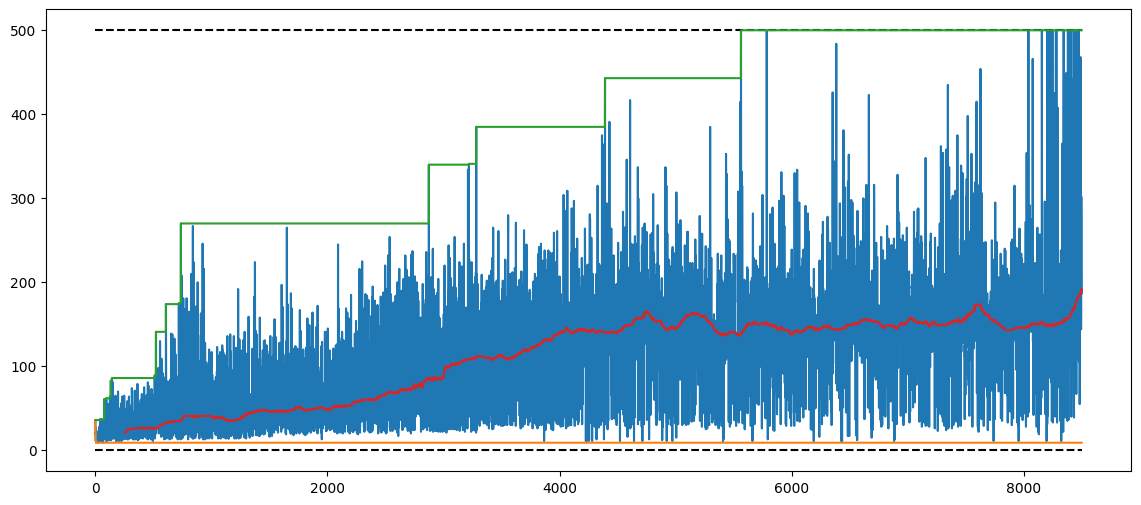

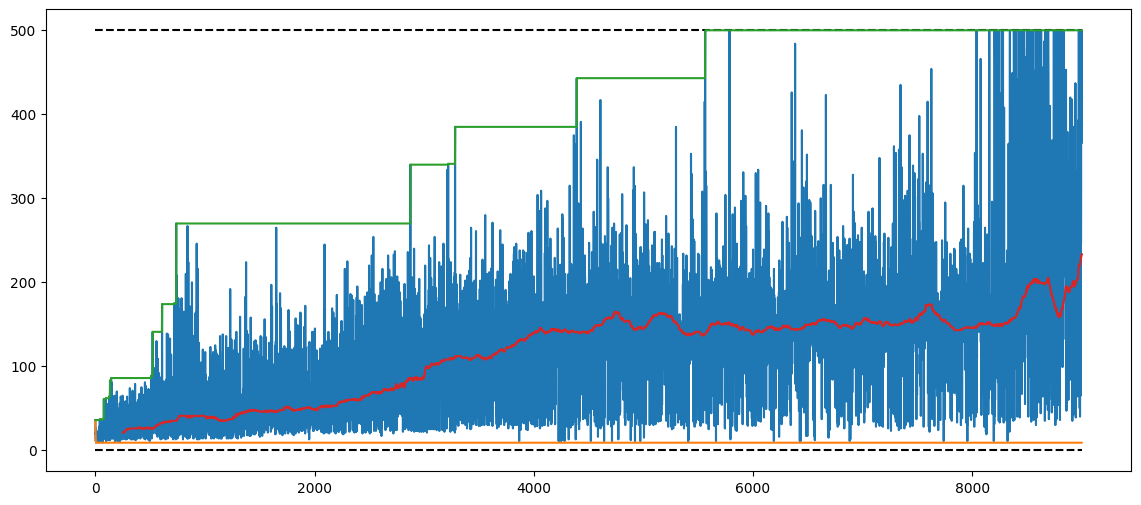

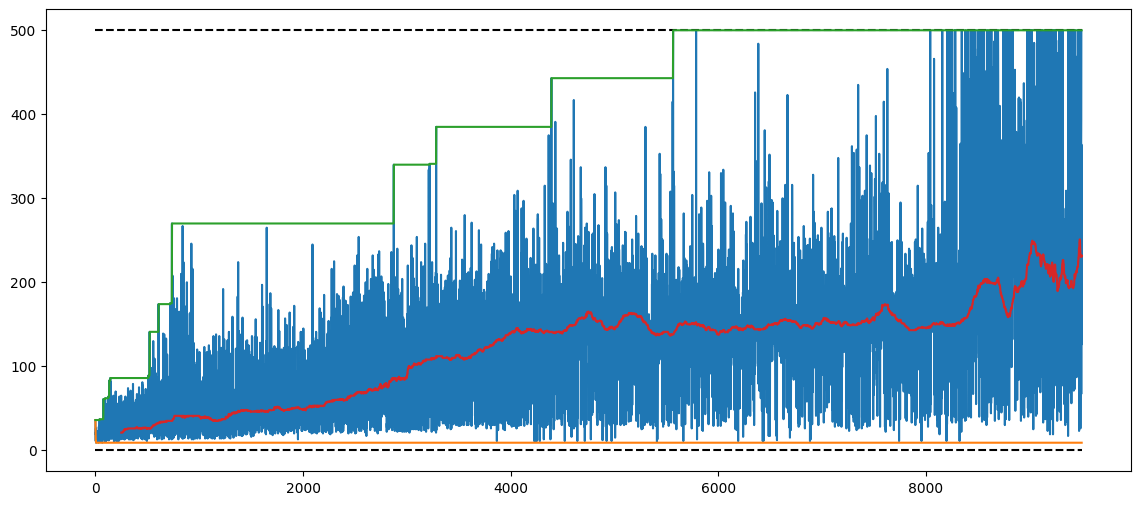

In [79]:
env = gym.make("CartPole-v1")
agent = TabularQLearningAgent(env)
rewards = run_agent_in_env(env, agent, 10_000, learning=True, plot=True, plot_interval=500)
print(f"Reward: {np.mean(rewards)}")

  0%|          | 0/4000 [00:00<?, ?it/s]

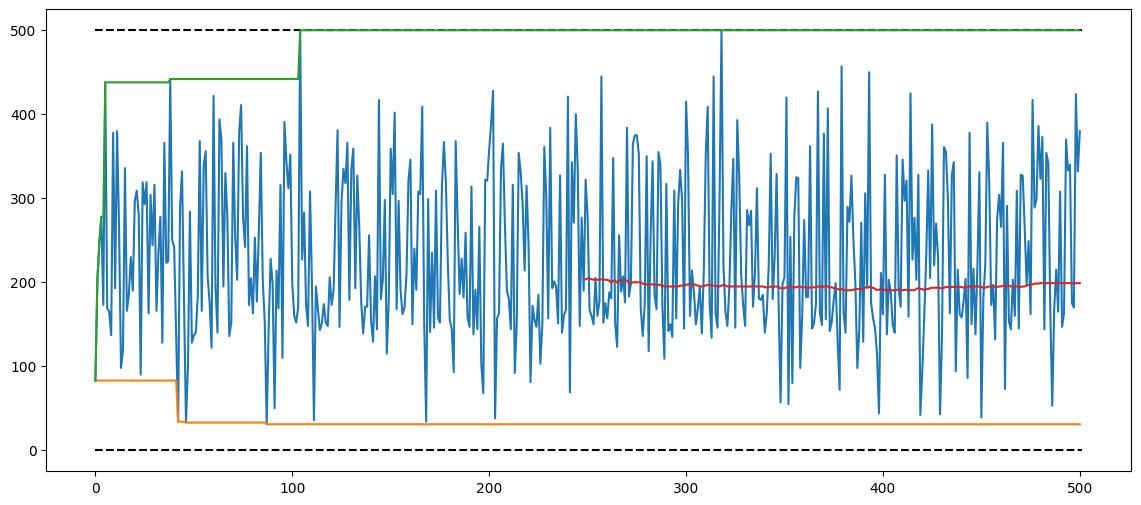

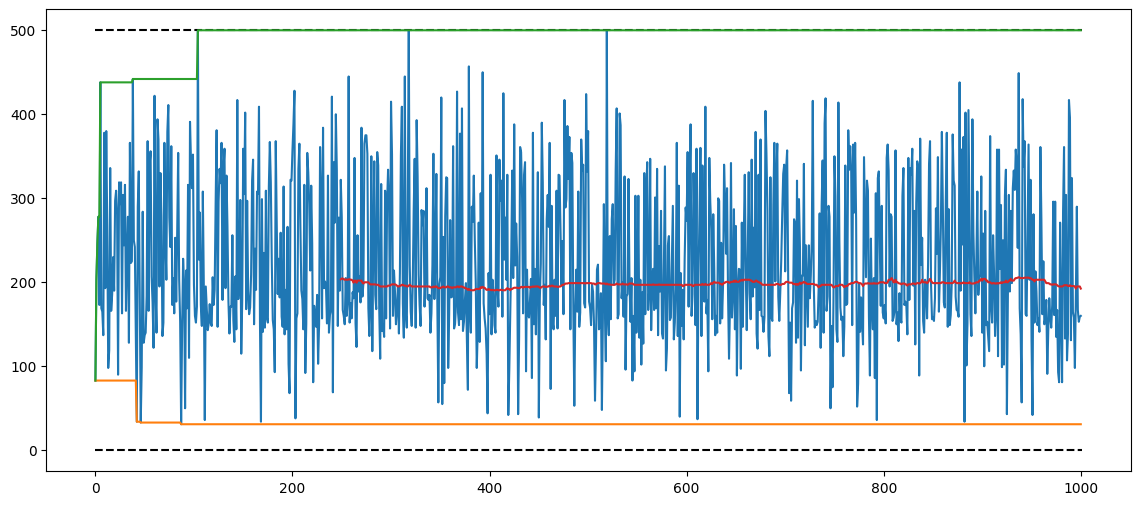

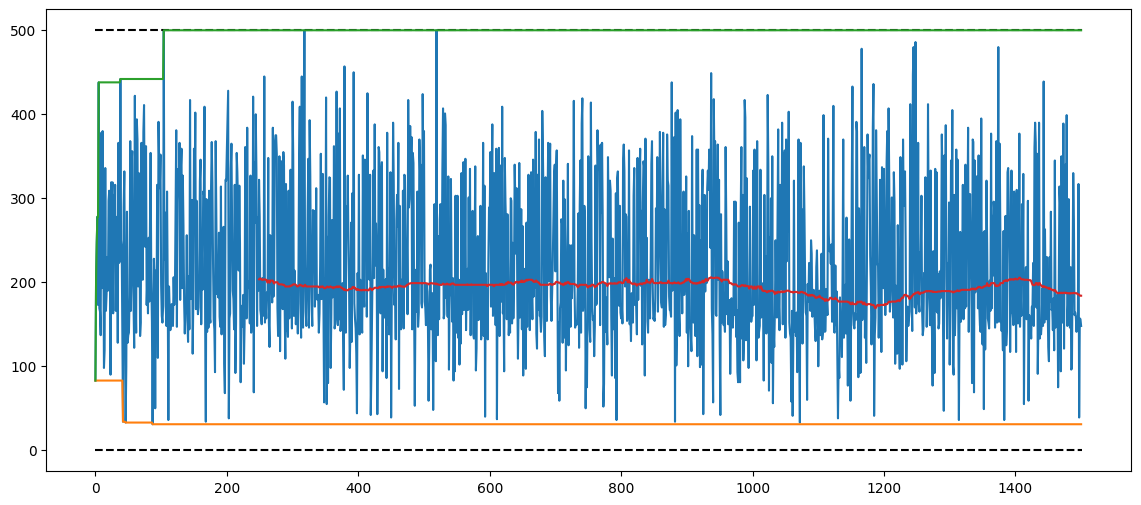

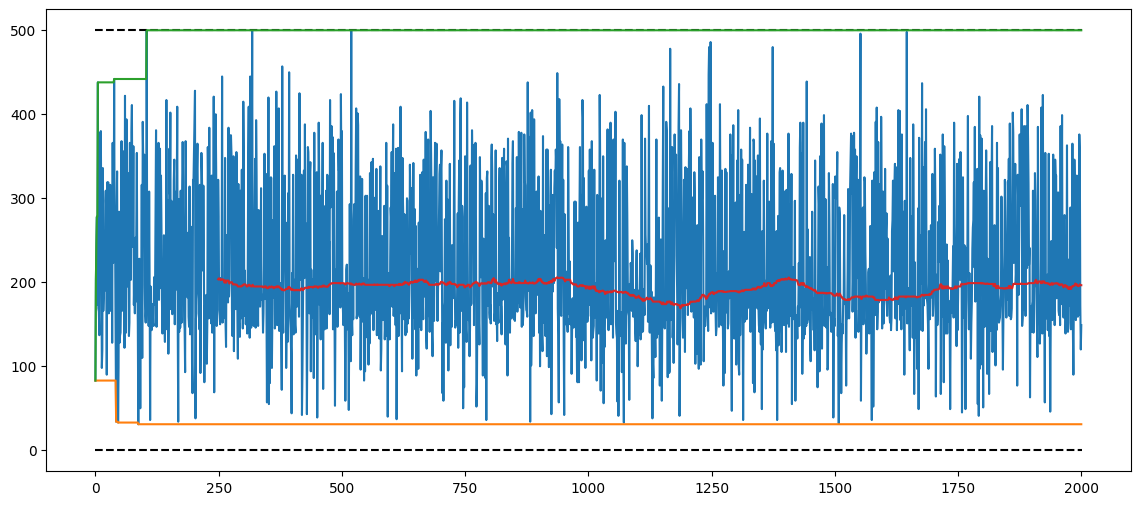

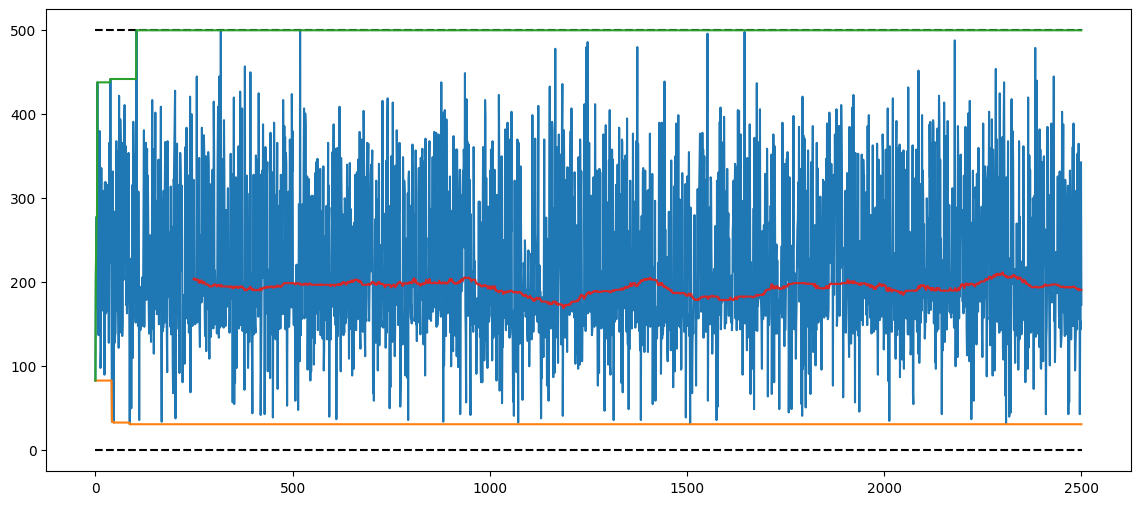

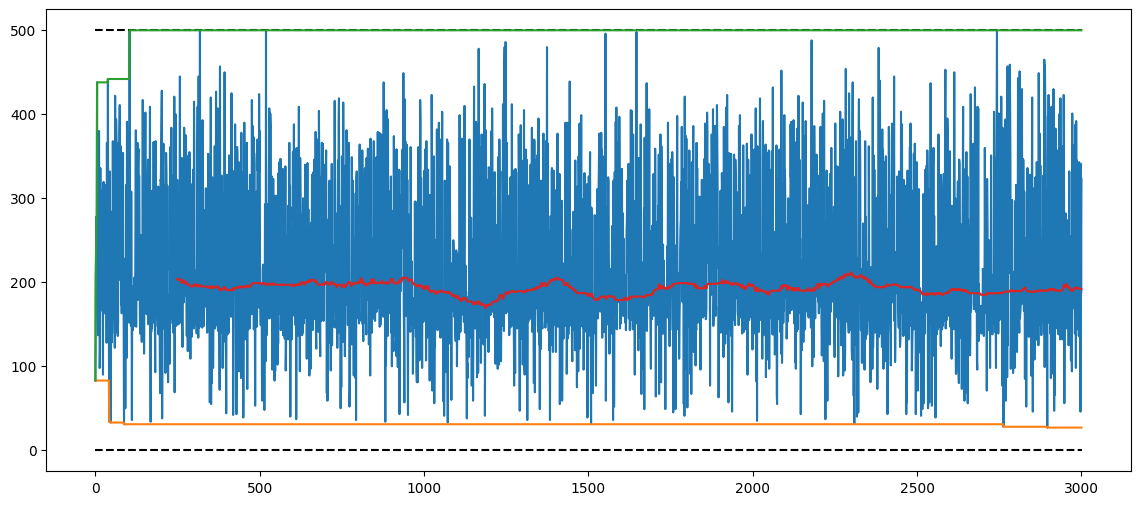

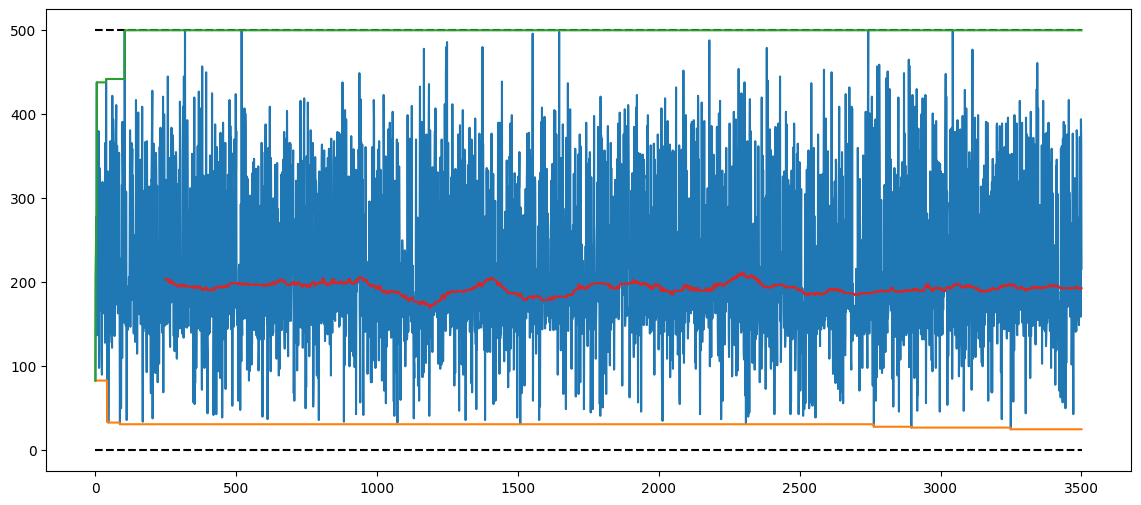

Reward: 222.57225


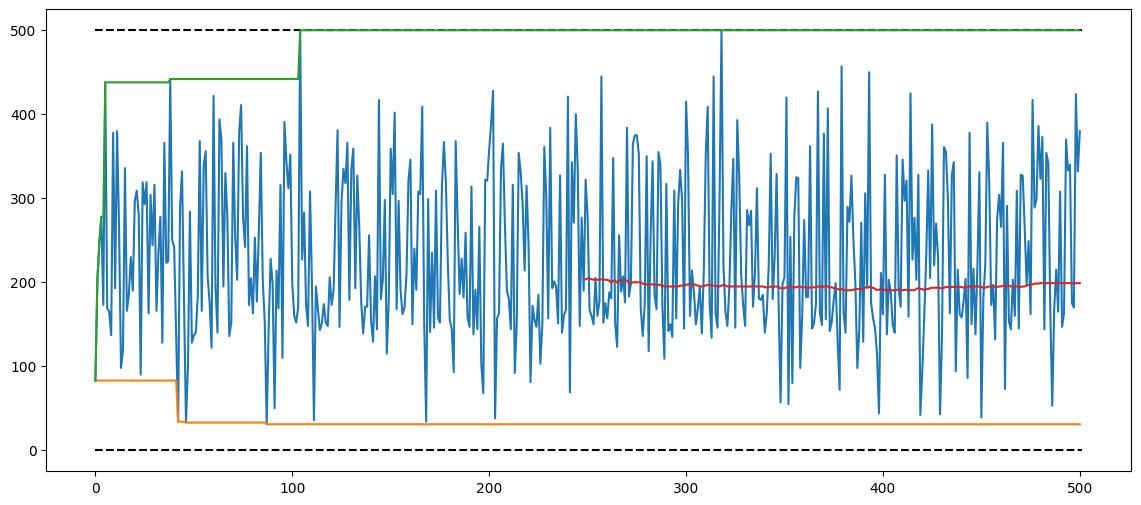

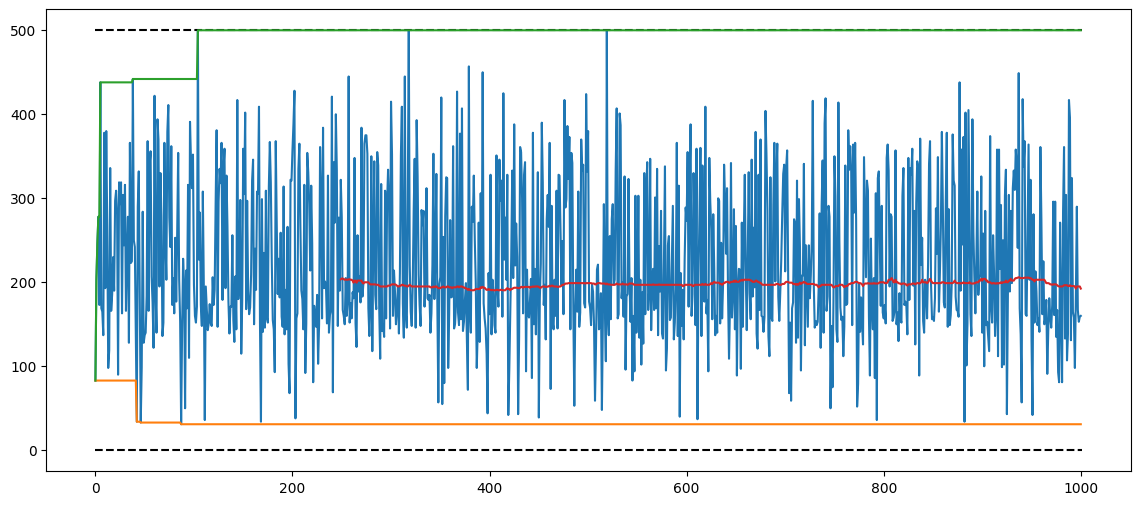

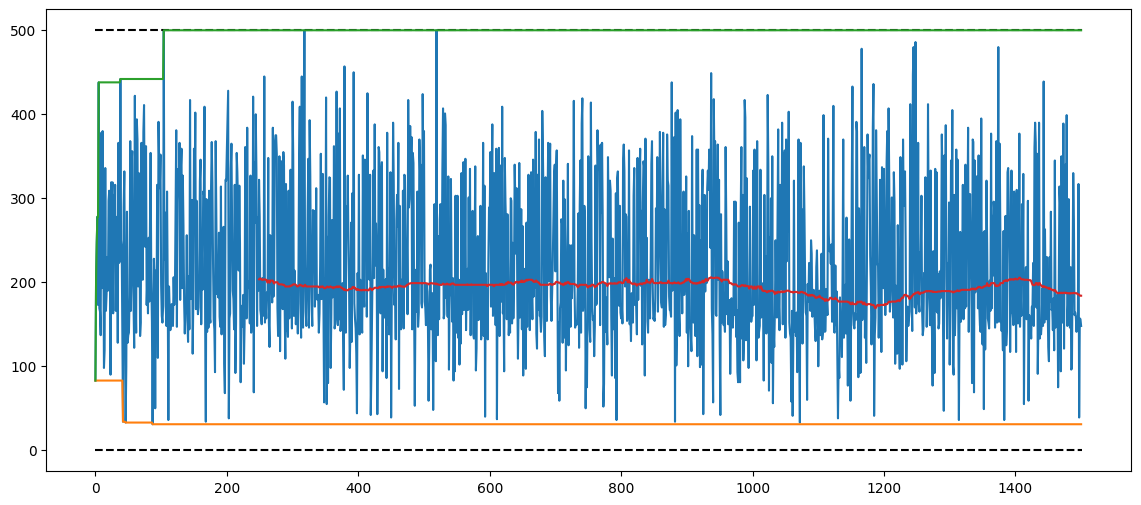

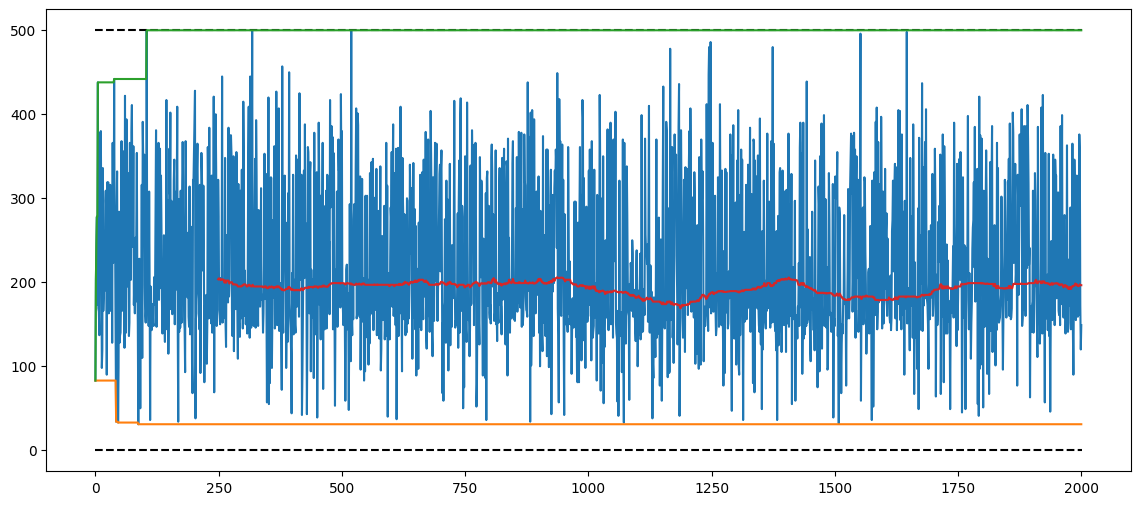

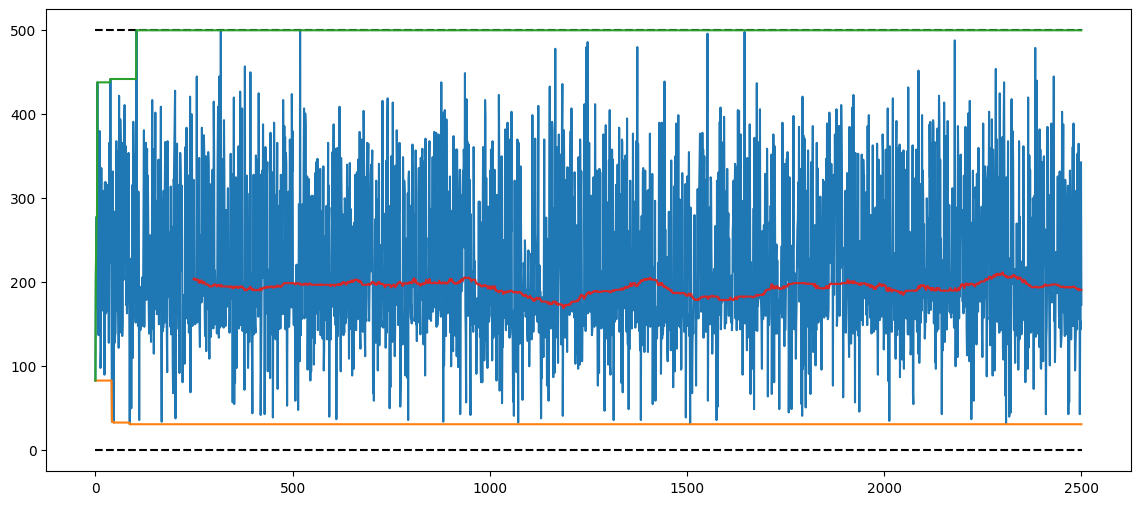

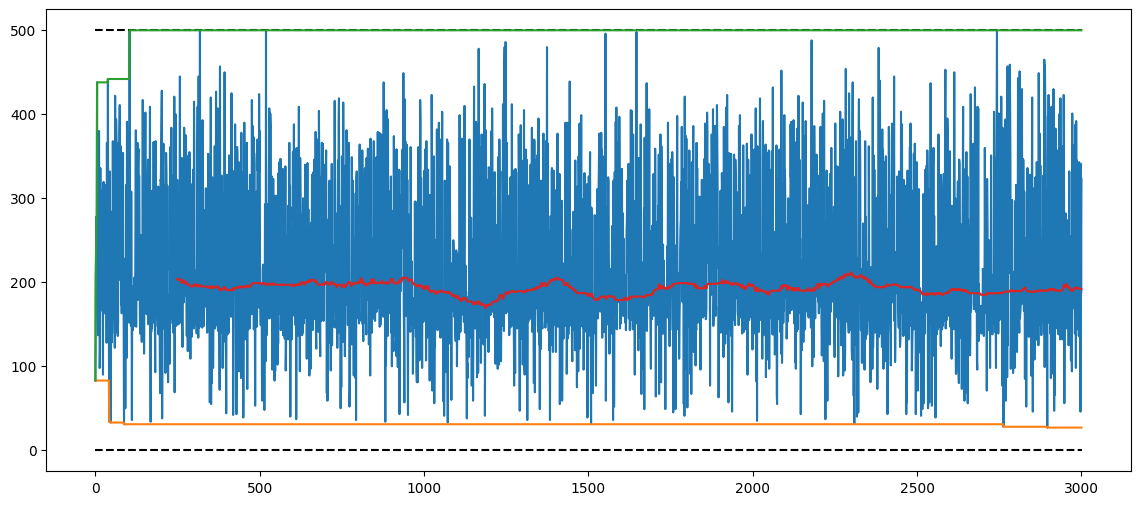

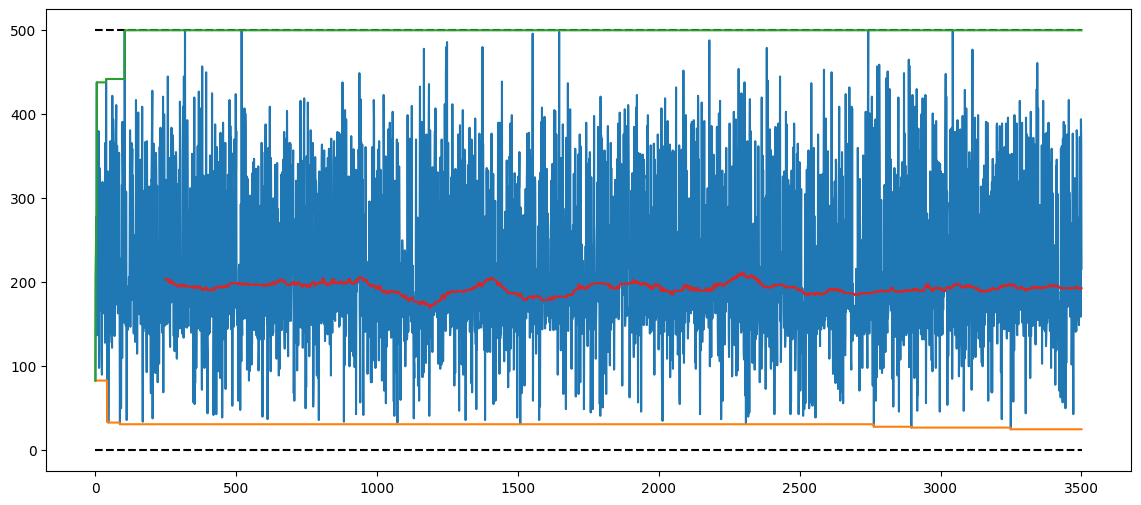

In [80]:

test_rewards = run_agent_in_env(env, agent, 4000, learning=False, plot=True, plot_interval=500)
print(f"Reward: {np.mean(test_rewards)}")

## Zad. 3.2 - Q-Learning z aproksymacją (25 pkt.)

W komórkach poniżej zaimplementuj Q-Learning z aproksymacją dla środowiska `LunarLander`, korzystający podczas uczenia się z polityki epsilon-greedy, a jako aproksymatora użyj prostej sieć neuronową zaimplementowanej z wykorzystaniem biblioteki PyTroch. Zaimplementuj następujące ulepszenia algorytmu Q-Learning:
- replay memory i uczenia batchowe zamiast uczenia online jak zrobiliśmy na zajęciach
- network freezing
- double q-learning

Porównaj ze sobą różne warianty algorytmu (nie duplikuj swojej implementacji, dodaj odpowiednie argumenty w konstruktorze, które będą włączać/wyłączać odpowiednie rozszerzenie), zademonstruj oczywiście swoje wyniki pozostawiając odpowiedni output z komórek oraz je skomentuj. Opisz również, jak dokonałeś doboru parametrów Twojego modelu.

Uwagi:
- Dobra polityka powinna mieć średnią bliską 100, bardzo dobra bliską 200.
- Uczenie nie powinno trwać więcej niż 10-15 minut (przy dobrze zaimplementowanych rozszerzeniach powinno być dużo szybsze) na CPU (możesz oczywiście użyć GPU jeśli masz taką możliwość, ale zadbaj, by domyślnie Twoja implementacja działała na CPU).
- Postaraj się dobrać i ustawić w `__init__` takie parametry (w tym architekturę sieci neuronowej) by Twój Agent uczył się i działał jak najlepiej. Są one pod Twoją kontrolą w klasie, więc możesz je odpowiednio kontrolować w trakcie uczenia.
- Założona architektura nie jest potrzebna do rozwiązania tego problemu, zacznij od prostego aproksymatora (np. liniowego albo sieci z dwoma warstwami) i stopniowo zwiększaj jego złożoność.
- Możesz najpierw testować swoją implementację na środowisku `CartPole`, jest to prostszy problem i z dobrymi parametrami nawet prosta wersja Q-Learningu z aproksymacją powinna się go uczyć w nie więcej niż 2-3 minuty na CPU.

#### Uwaga: nie zmieniaj nazwy klasy `NeuralQLearningAgent`, ani pozycyjnych (tych bez wartości domyślnych) argumentów jej metod, możesz dopisywać argumenty z wartościami domyślnymi oraz oczywiście pomocnicze metody do klasy. Pomocnicze metody powinny być w tej samej komórce (sprawdzarka wyciągnie ze zgłoszonego notebooka wyłącznie komórkę z klasą `NeuralQLearningAgent`, kod w innych komórkach nie będzie widziany przez sprawdzarkę!). Nie dopisuj do komórki z klasą innego kodu.

Odpowiedzi: Miejsce na Twoje odpowiedzi

In [89]:
from collections import namedtuple
from typing import List
from random import choices
from gymnasium import Env
import numpy as np
import torch
from torch import Tensor


class Configuration(dict):
  __getattr__ = dict.get
  __setattr__ = dict.__setitem__
  __delattr__ = dict.__delitem__


Experience = namedtuple("Experience", field_names=[
  "state",
  "action",
  "reward",
  "next_state",
  "done"
])


class MemoryModule(object):
  def __init__(self, capacity: int = None) -> None:
    self.contents = deque(maxlen=capacity)

  def __len__(self) -> int:
    return len(self.contents)

  def append(self, experience: Experience) -> None:
    self.contents.append(experience)

  def sample(self, count: int) -> List[Experience]:
    return choices(self.contents, k=count)


class ModelModule(torch.nn.Module):
  def __init__(self, input_size: int, hidden_sizes: List[int], output_size: int):
    super().__init__()

    self.model = torch.nn.Sequential(
      torch.nn.Linear(input_size, hidden_sizes[0]),
      torch.nn.ReLU(),
      *[layer for i in range(len(hidden_sizes) - 1) for layer in [
        torch.nn.Linear(hidden_sizes[i], hidden_sizes[i + 1]),
        torch.nn.ReLU()
      ]],
      torch.nn.Linear(hidden_sizes[-1], output_size)
    )

  def forward(self, x): return self.model(x)

  def sync_with(self, other: 'ModelModule'):
    self.load_state_dict(other.state_dict())

  def update_params(self, other: 'ModelModule', influence: float):
    for owned, influencer in zip(self.parameters(), other.parameters()):
      owned.data = owned.data * (1.0 - influence) + influencer.data * influence

In [90]:
class NeuralQLearningAgent(Agent):
  def __init__(
      self, env: Env,
      network: Configuration,
      use_memory: Configuration = None,
      use_double: Configuration = None,
      use_freeze: Configuration = None
  ):
    super().__init__(env)

    def create_model():
      return ModelModule(self.env.observation_space.shape[0], network.layers, self.env.action_space.n)
    self.env = env

    self.uses_memory = bool(use_memory)
    self.uses_double = bool(use_double)
    self.uses_freeze = bool(use_freeze)

    # Memory-parameters
    self.memory = MemoryModule(use_memory.capacity)
    self.update_frequency = use_memory.update_frequency
    self.batch_size = use_memory.batch_size

    # Double-parameters
    self.online_model = create_model()
    self.target_model = create_model()
    self.target_model.sync_with(self.online_model)
    self.influence = use_double.influence

    # Freeze-parameters
    self.freeze_frequency = use_freeze and use_freeze.frequency

    # Hyper-parameters
    self.optimizer = torch.optim.RMSprop(self.online_model.parameters(), lr=0.001)
    self.loss_fn = torch.nn.MSELoss()
    self.gamma = 0.99
    self.epsilon = 1
    self.epsilon_decay = 0.99
    self.iterations = 0

  def update(self, states, rewards, dones, online, target):
    _, actions = online(states).max(dim=1, keepdim=True)
    next_q_values = target(states).gather(dim=1, index=actions)
    return rewards + self.gamma * next_q_values * (1 - dones)

  def single_update(self, states, rewards, dones):
    return self.update(states, rewards, dones, self.target_model, self.target_model)

  def double_update(self, states, rewards, dones):
    return self.update(states, rewards, dones, self.online_model, self.target_model)

  def get_action(self, observation, learning):
    if not self.can_train or (learning and np.random.random() < self.epsilon): return self.env.action_space.sample()

    state = (torch.from_numpy(observation).unsqueeze(dim=0))
    return self.online_model(state).argmax().item()

  def train(self, experiences: List[Experience]) -> None:
    states, actions, rewards, next_states, dones = map(Tensor, zip(*experiences))

    actions = actions.long().unsqueeze(dim=1)
    rewards = rewards.unsqueeze(dim=1)
    dones = dones.unsqueeze(dim=1)

    if self.uses_double:
      target = self.double_update(next_states, rewards, dones)
    else:
      target = self.single_update(next_states, rewards, dones)

    predicted = self.online_model(states).gather(dim=1, index=actions)
    loss = self.loss_fn(predicted, target)

    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

    self.target_model.update_params(self.online_model, self.influence)

  @property
  def should_train(self) -> bool:
    return not self.uses_memory or self.iterations % self.update_frequency == 0

  @property
  def can_train(self) -> bool:
    return not self.uses_memory or len(self.memory) >= self.batch_size

  @property
  def should_freeze(self):
    return self.uses_freeze and self.iterations % self.freeze_frequency == 0

  def process_transition(self, observation, action, reward, next_observation, done):
    experience = Experience(observation, action, reward, next_observation, done)
    self.memory.append(experience)
    self.iterations += 1

    if self.should_train and self.can_train:
      if self.uses_memory:
        self.train(self.memory.sample(self.batch_size))
      else:
        self.train([experience])

      if not self.uses_freeze:
        self.target_model.update_params(self.online_model, self.influence)

    if self.should_freeze:
      self.target_model.sync_with(self.online_model)

    if done: self.update_epsilon()

  def update_epsilon(self) -> float:
    self.epsilon = max(0.01, self.epsilon * self.epsilon_decay)


In [91]:
# check gpu
import torch

print(torch.cuda.is_available())

# check if used
print(torch.cuda.device(0))
print(torch.cuda.get_device_name(0))


True
NVIDIA GeForce RTX 3070 Laptop GPU


  0%|          | 0/10000 [00:00<?, ?it/s]

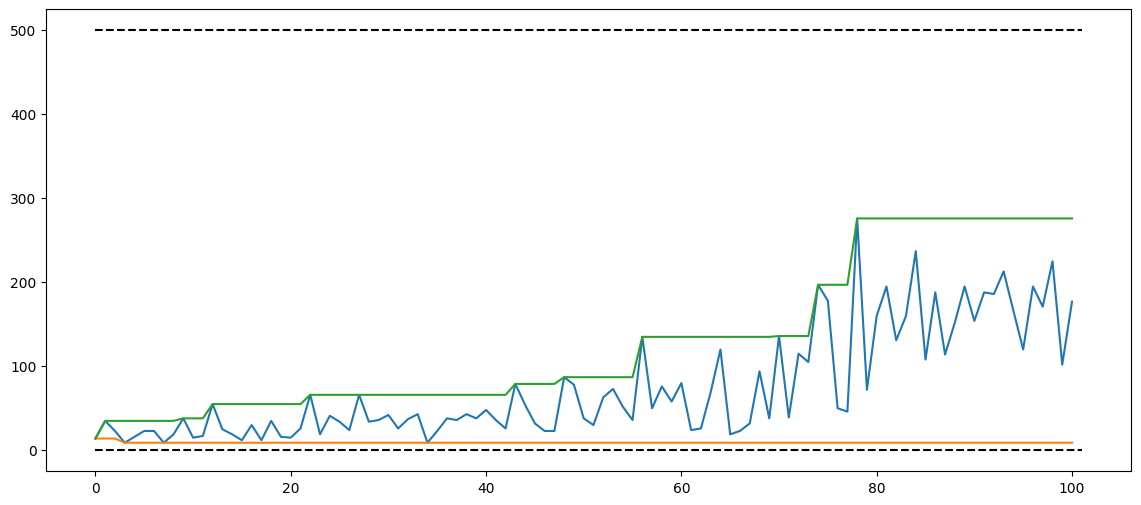

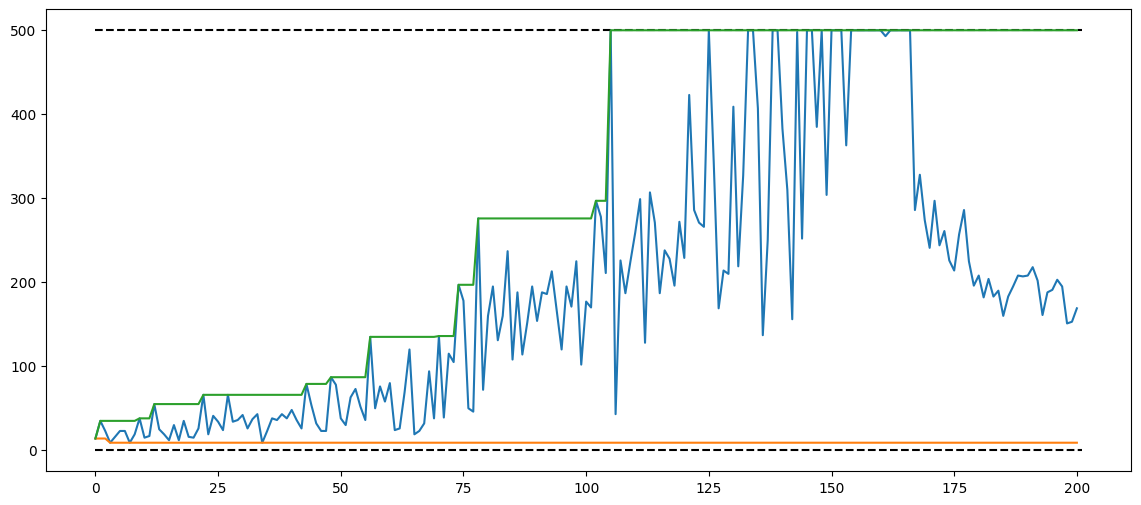

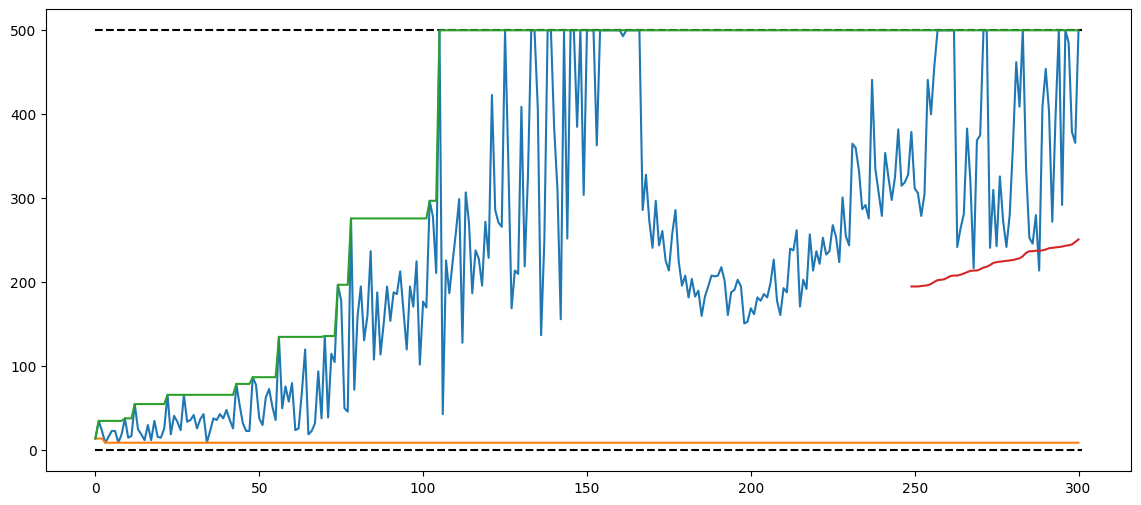

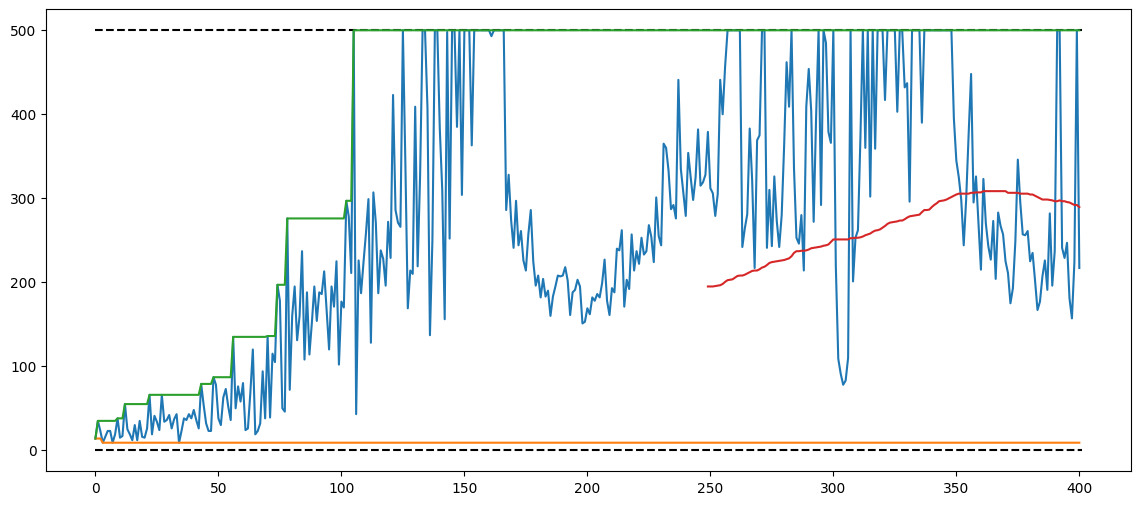

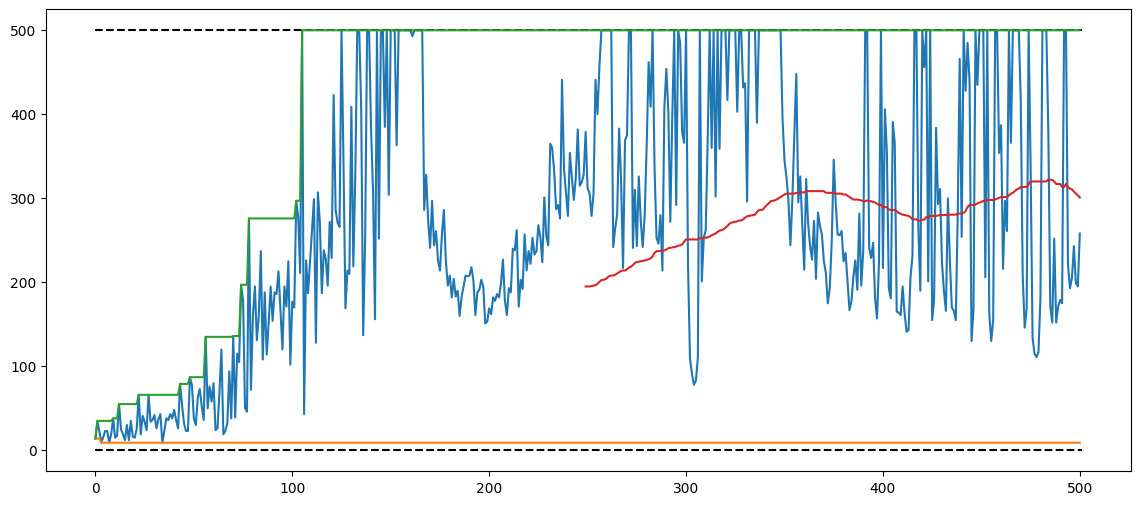

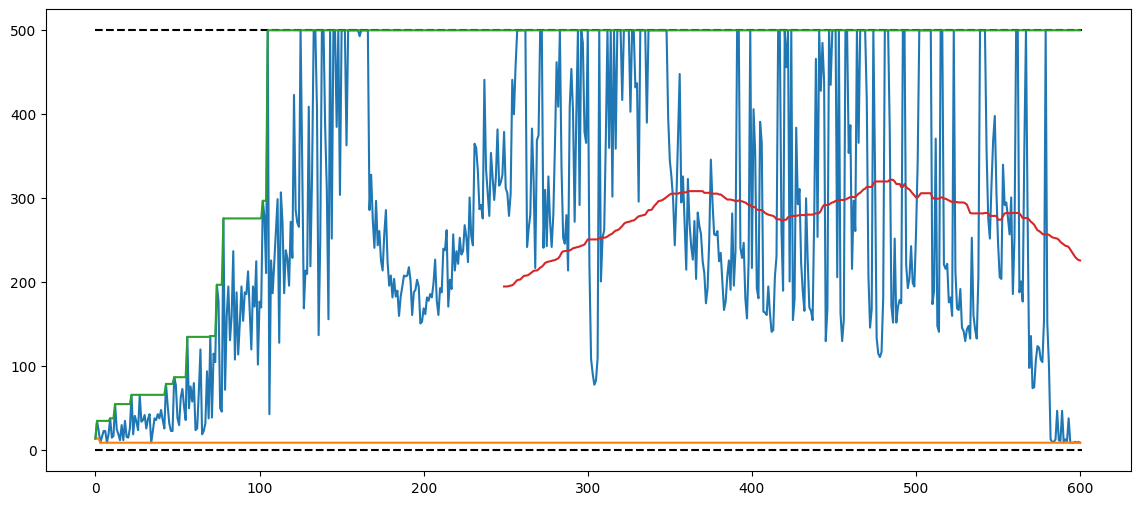

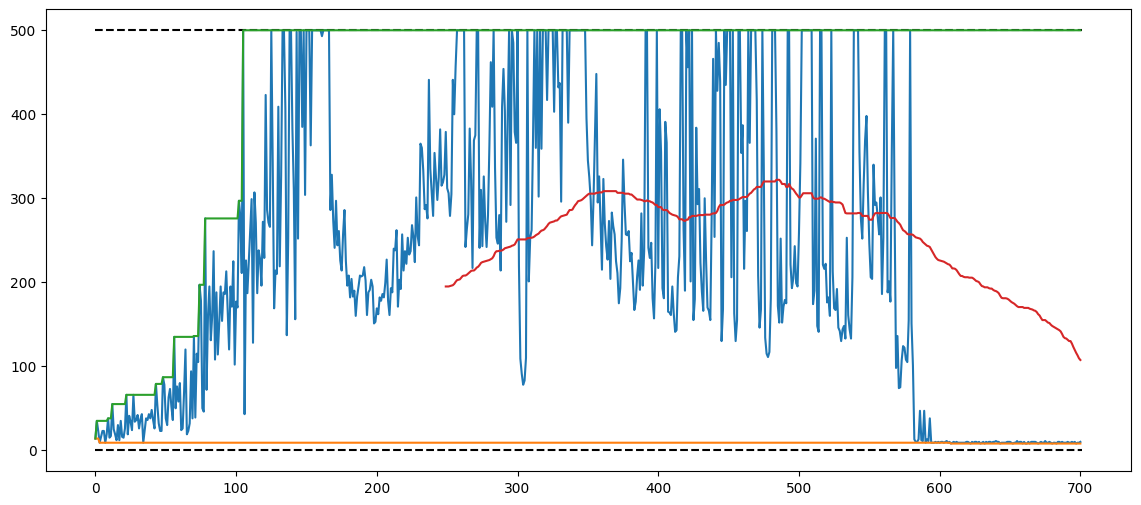

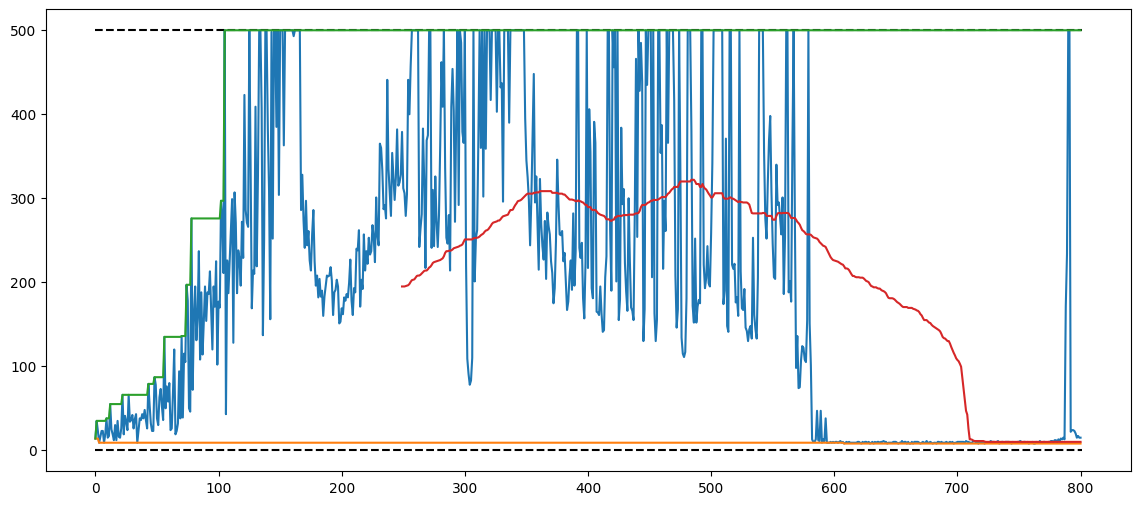

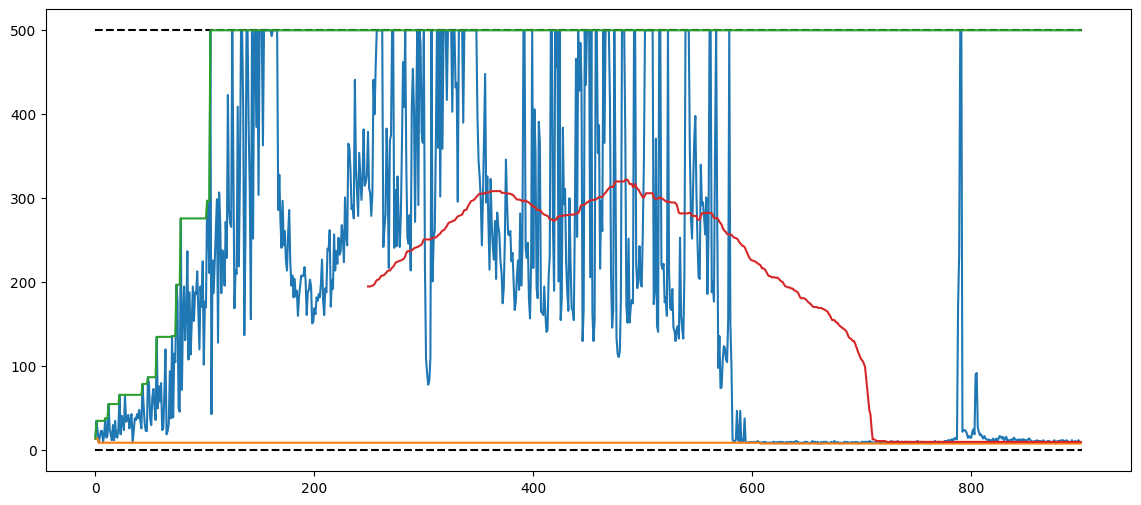

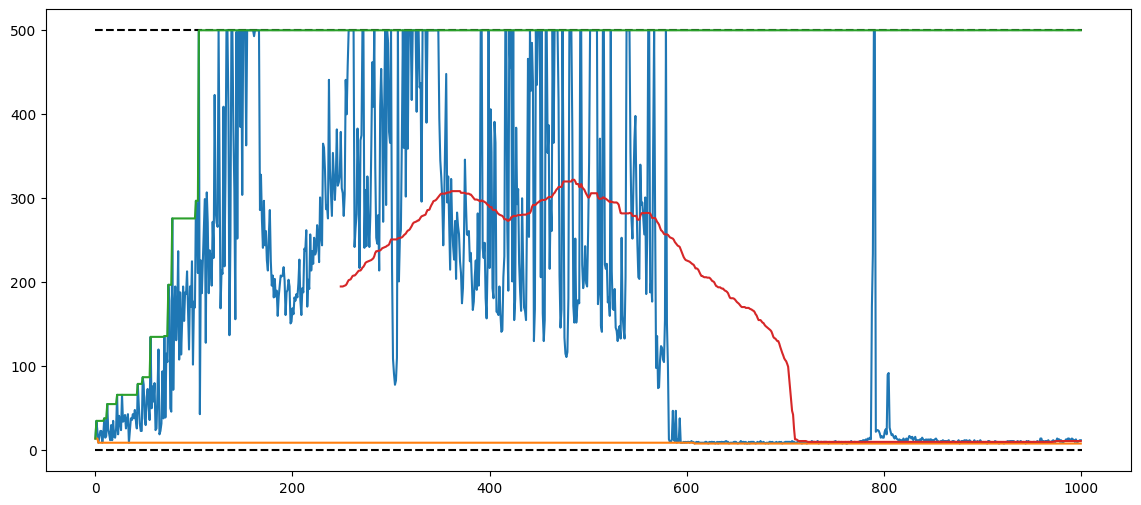

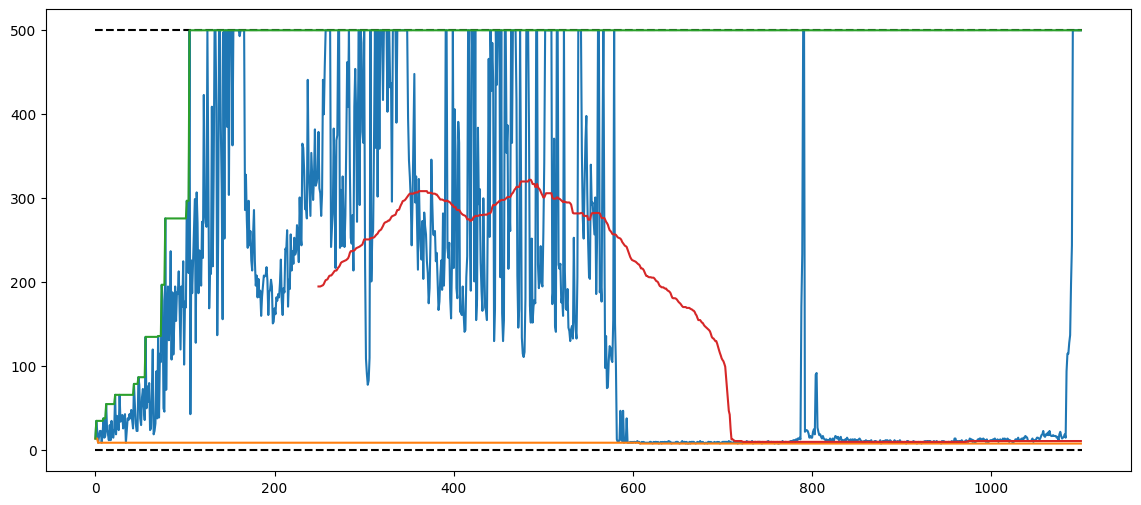

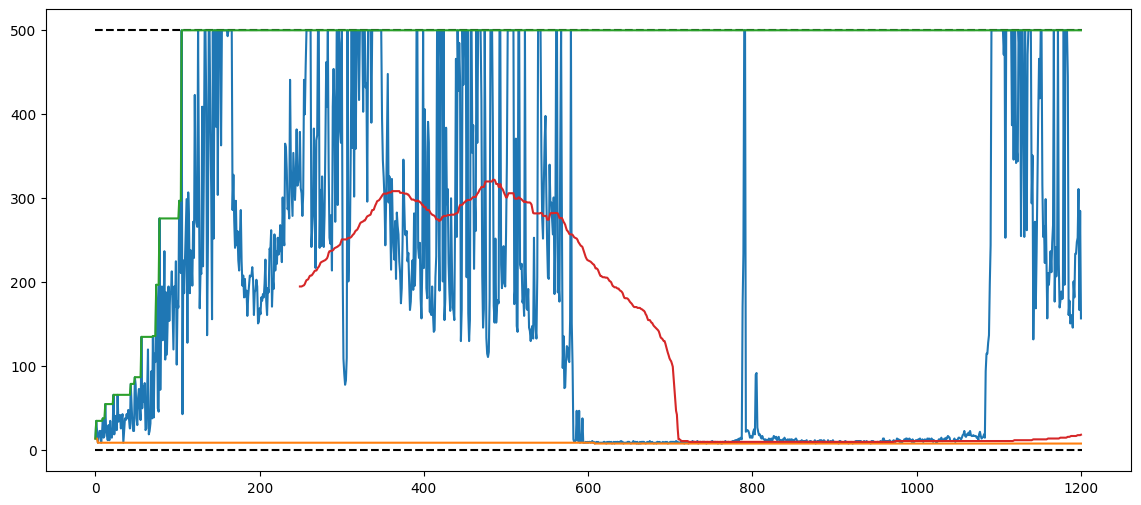

KeyboardInterrupt: 

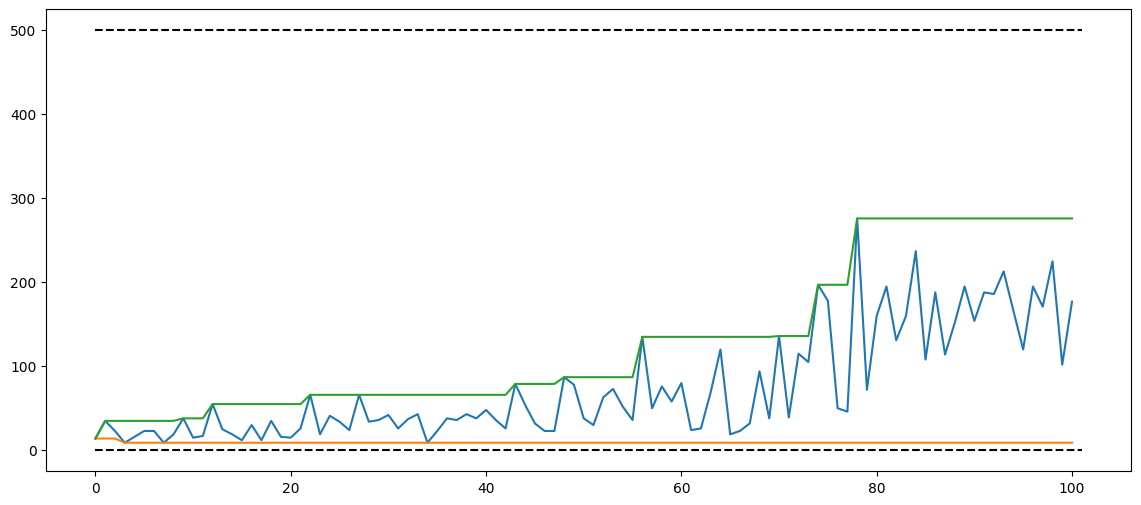

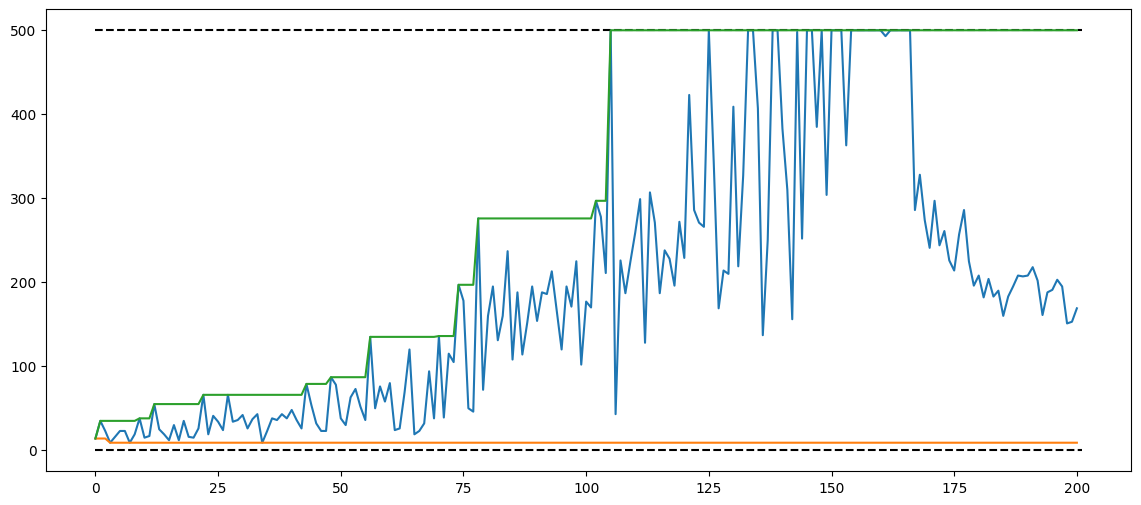

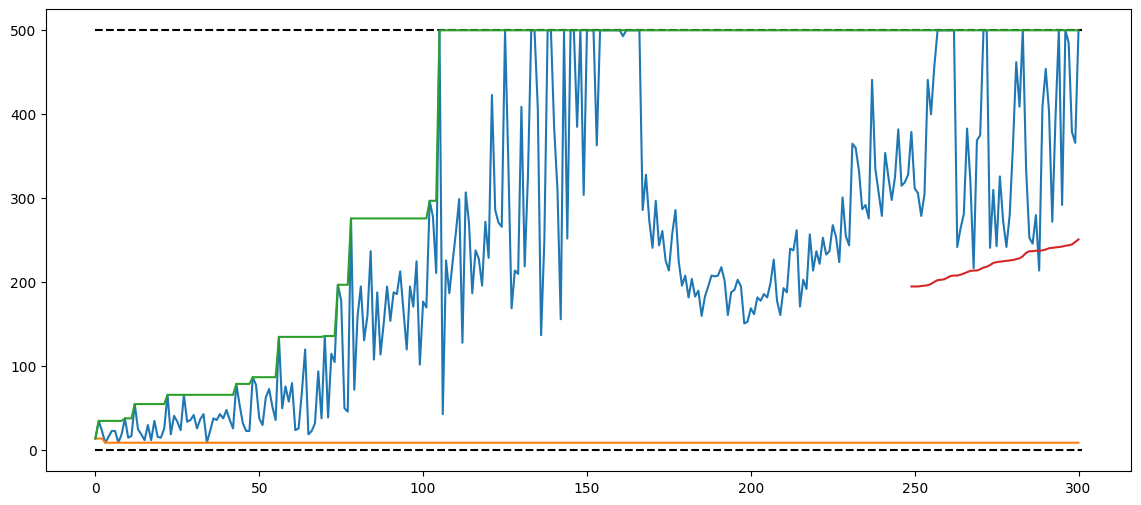

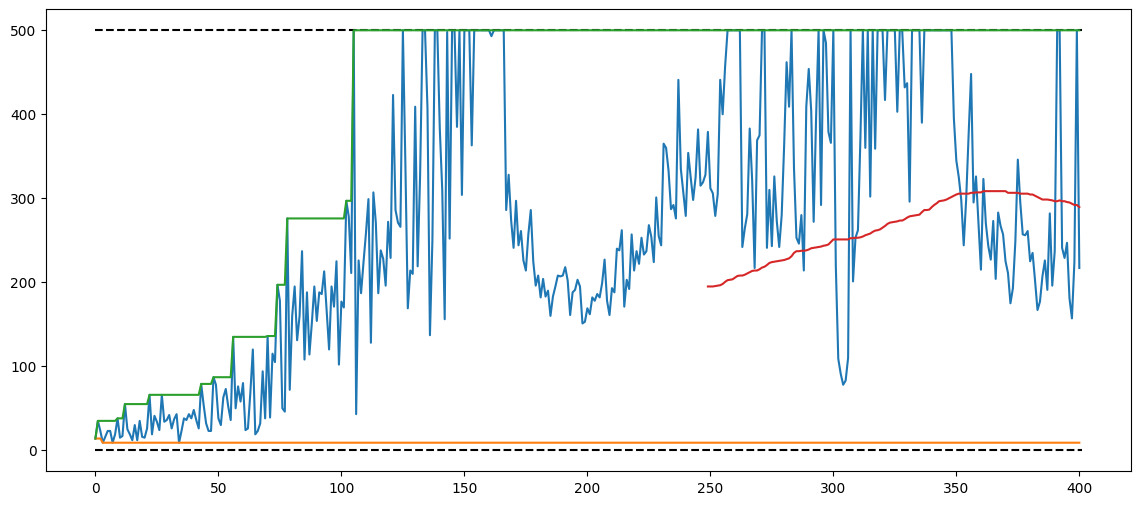

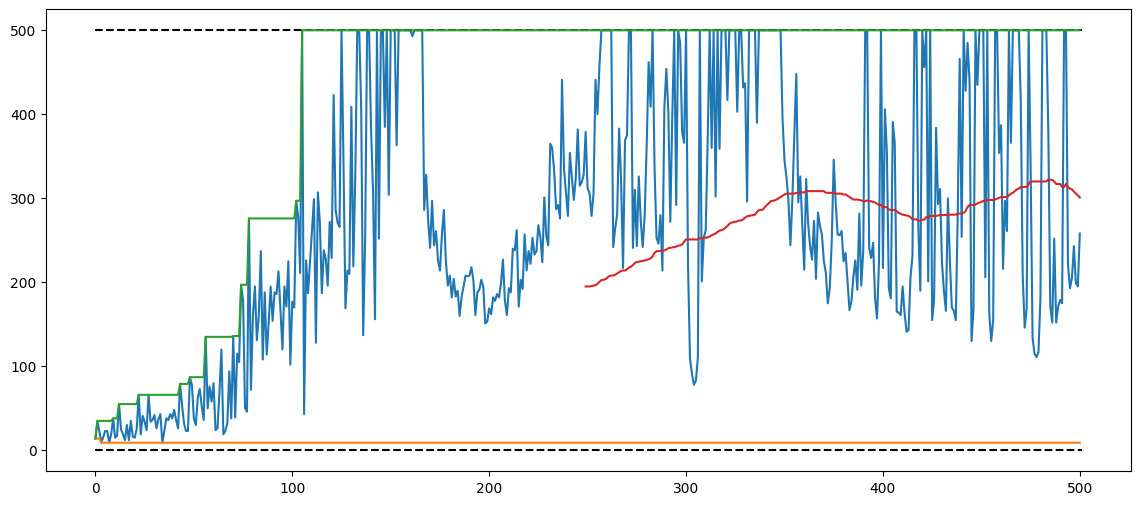

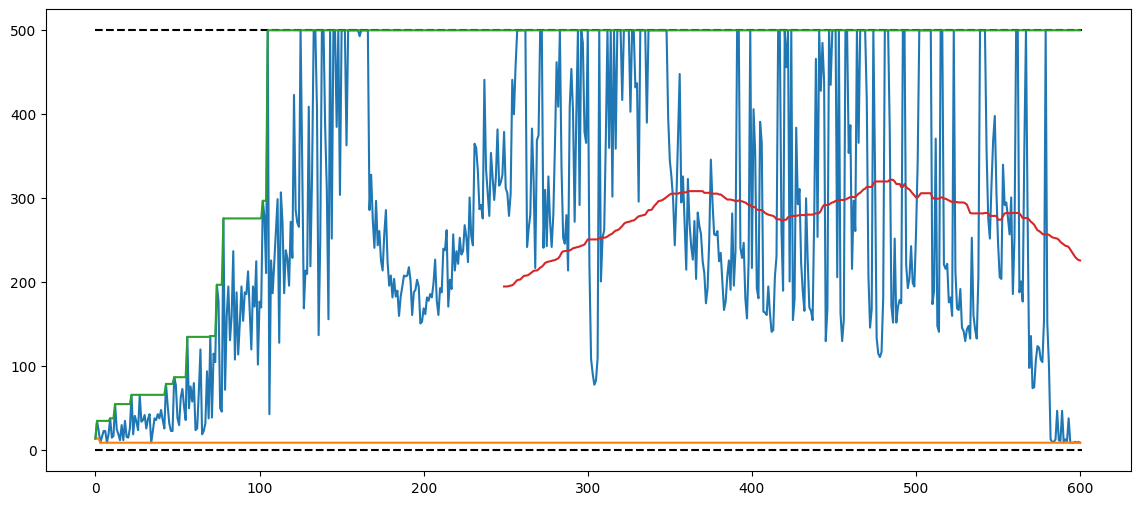

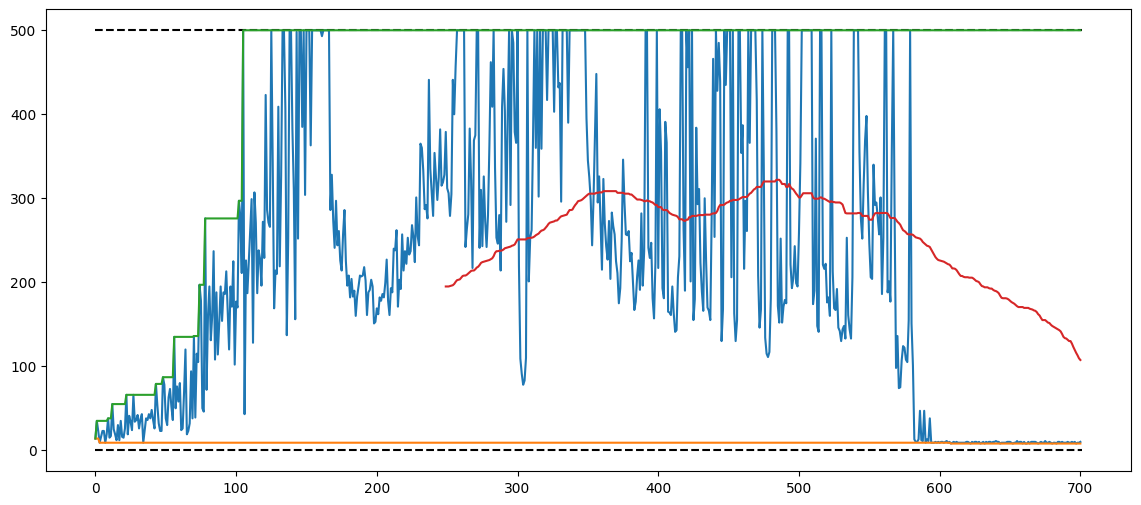

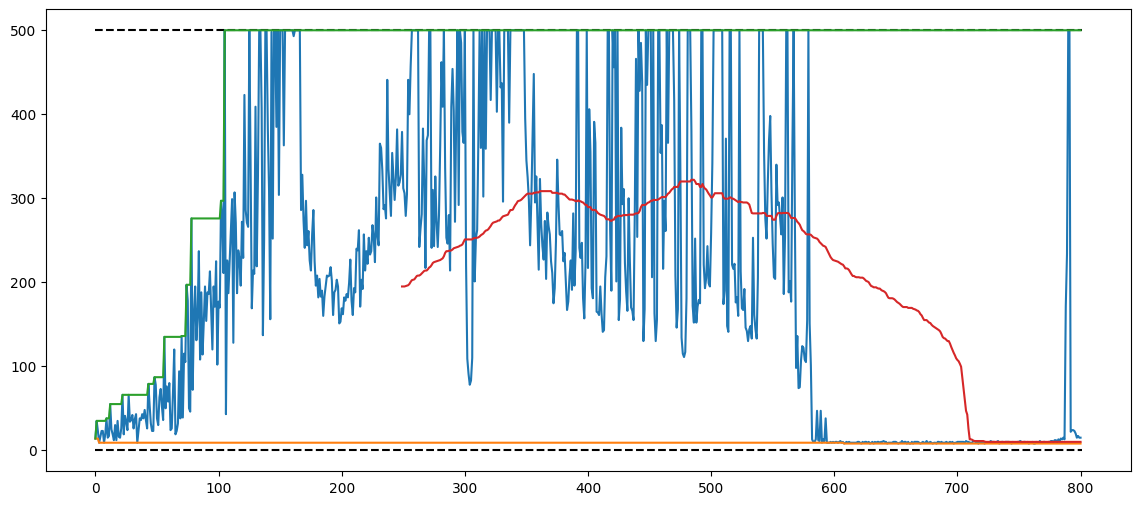

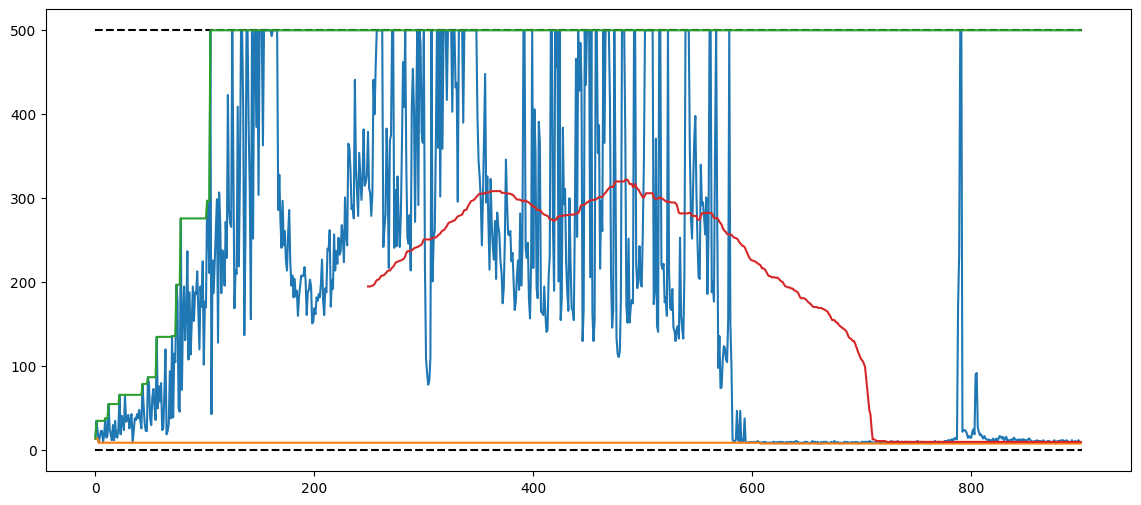

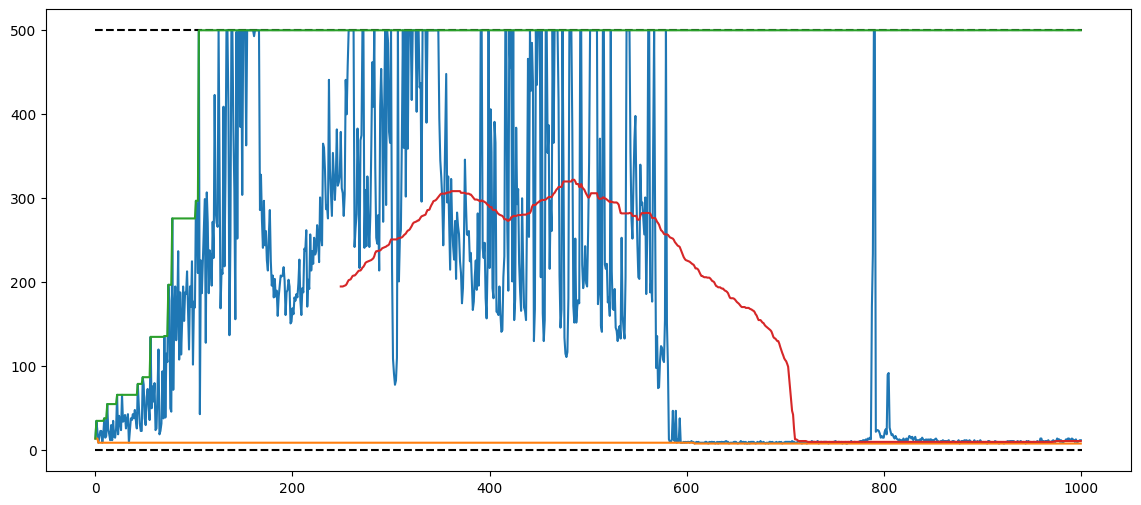

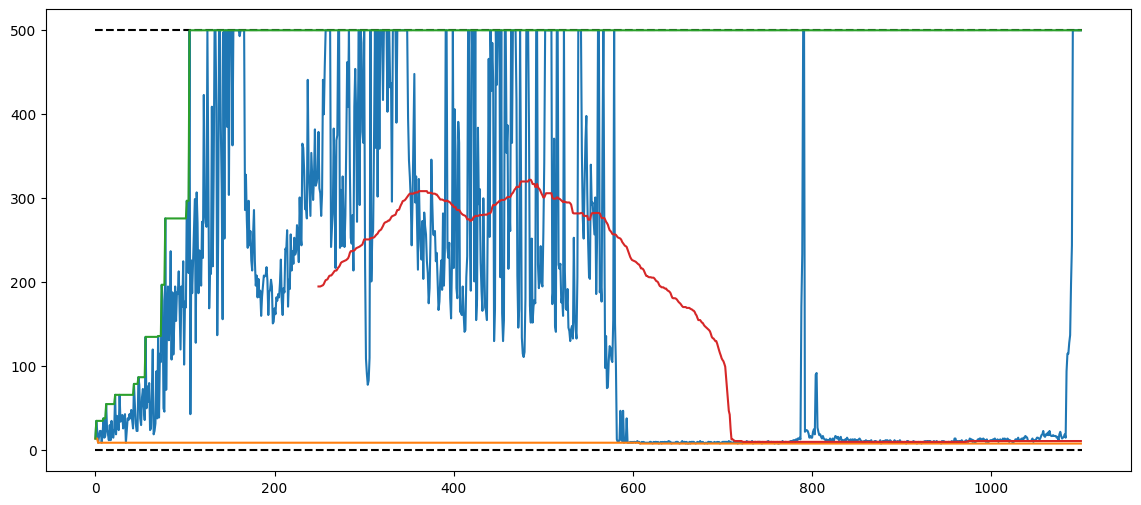

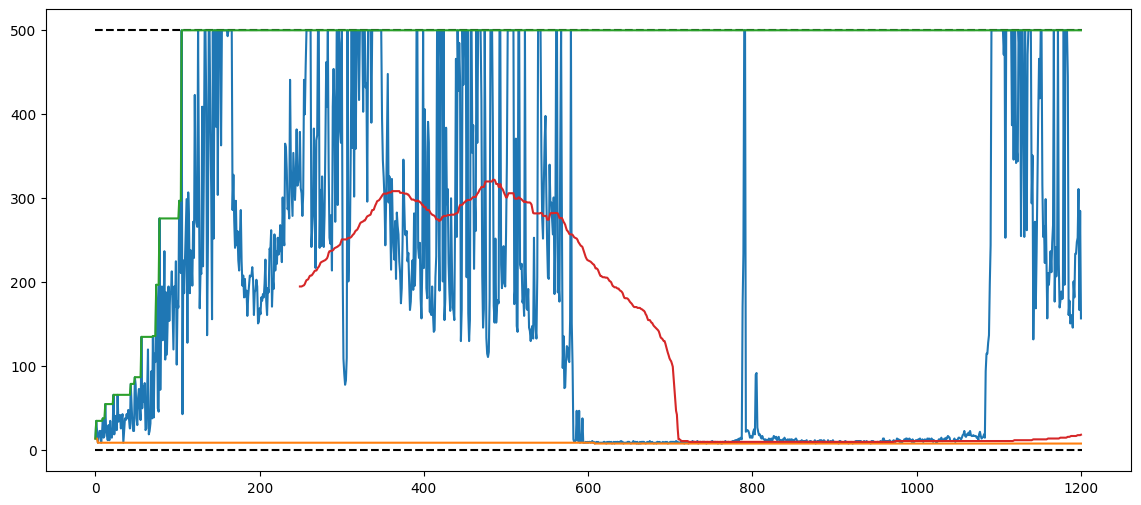

In [92]:

env = gym.make("CartPole-v1")
network = Configuration(layers=[128, 128])
memory = Configuration(update_frequency=4, batch_size=32, capacity=1_000_000)
double = Configuration(influence=0.001)
freeze = Configuration(frequency=10)
agent = NeuralQLearningAgent(env, network=network, use_memory=memory, use_double=double, use_freeze=freeze)
rewards = run_agent_in_env(env, agent, 10_000, learning=True, plot=True, plot_interval=100)

  0%|          | 0/400 [00:00<?, ?it/s]

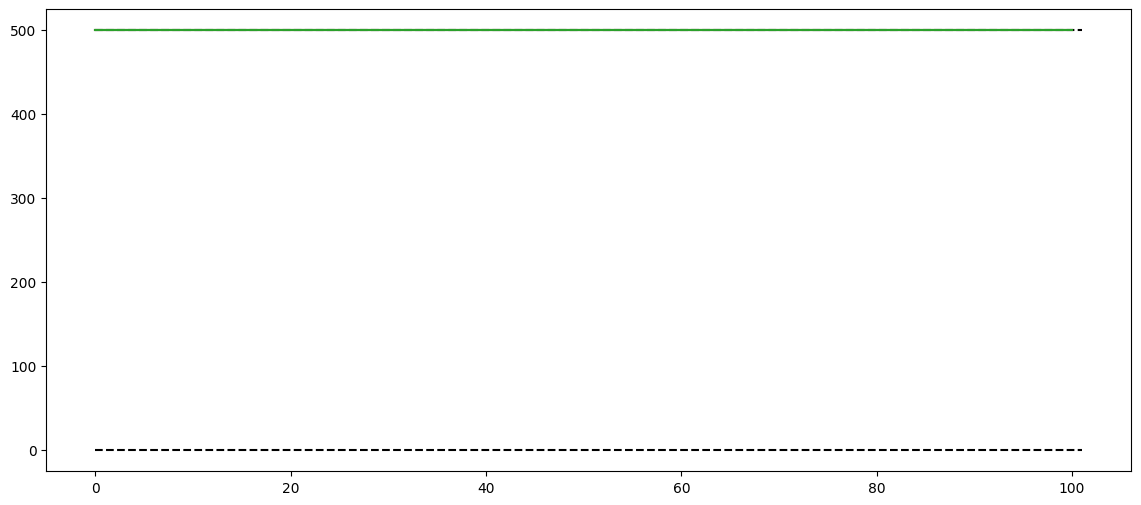

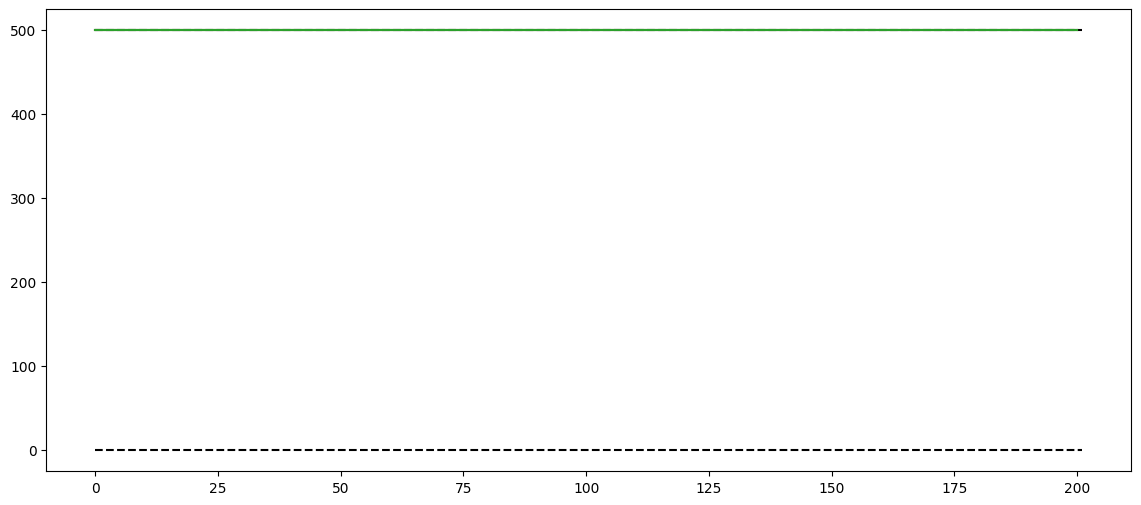

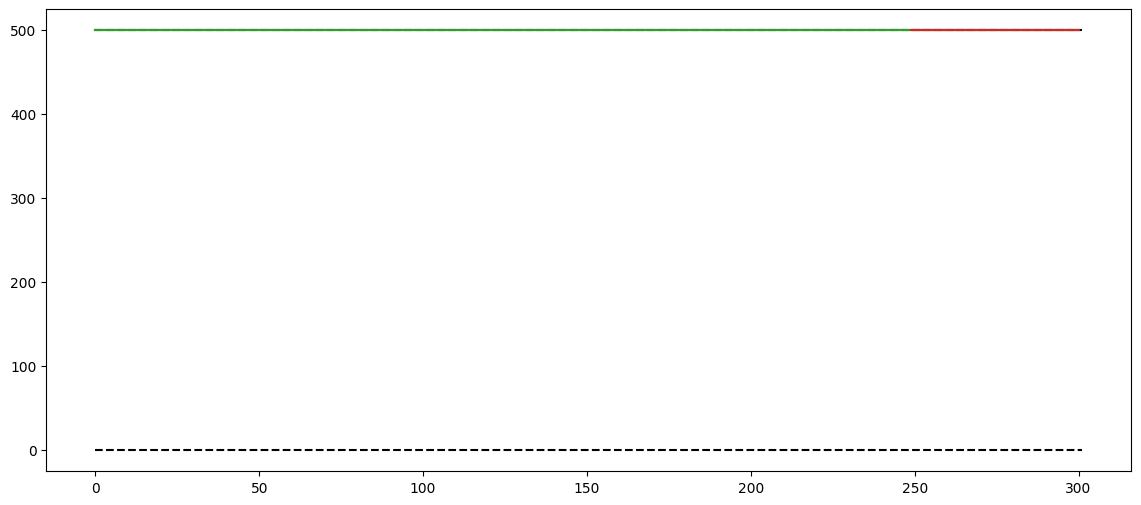

Reward: 500.00


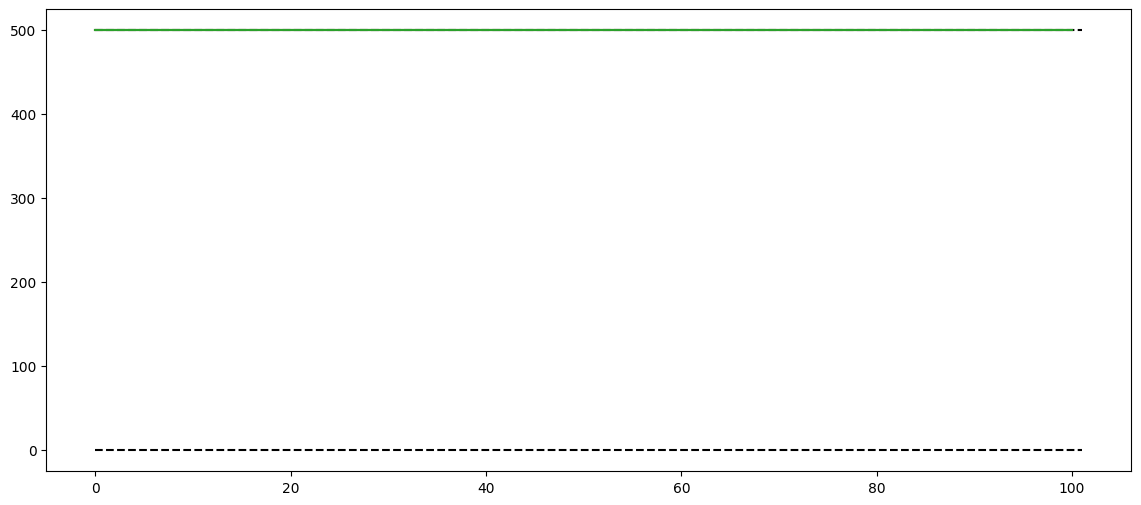

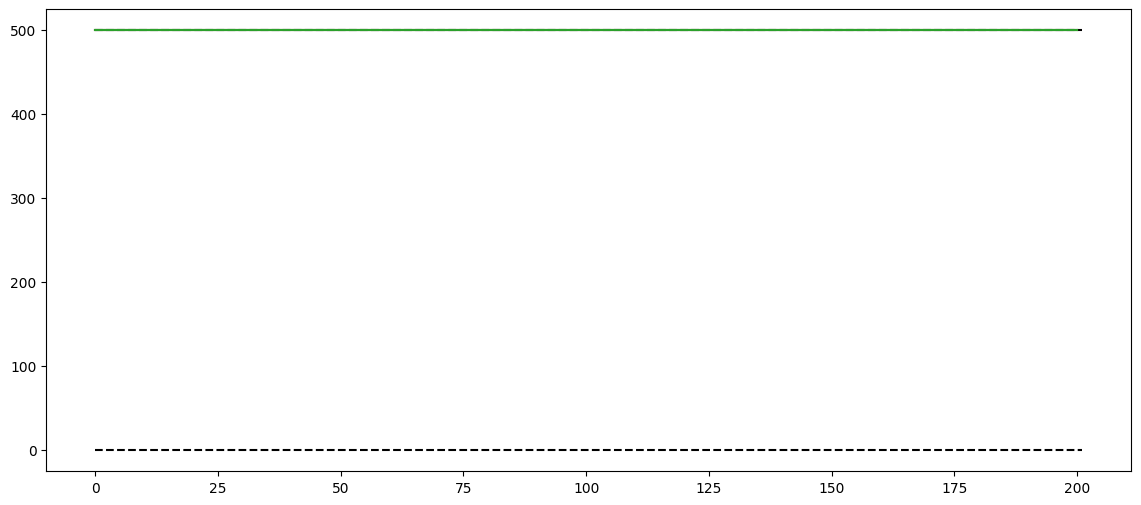

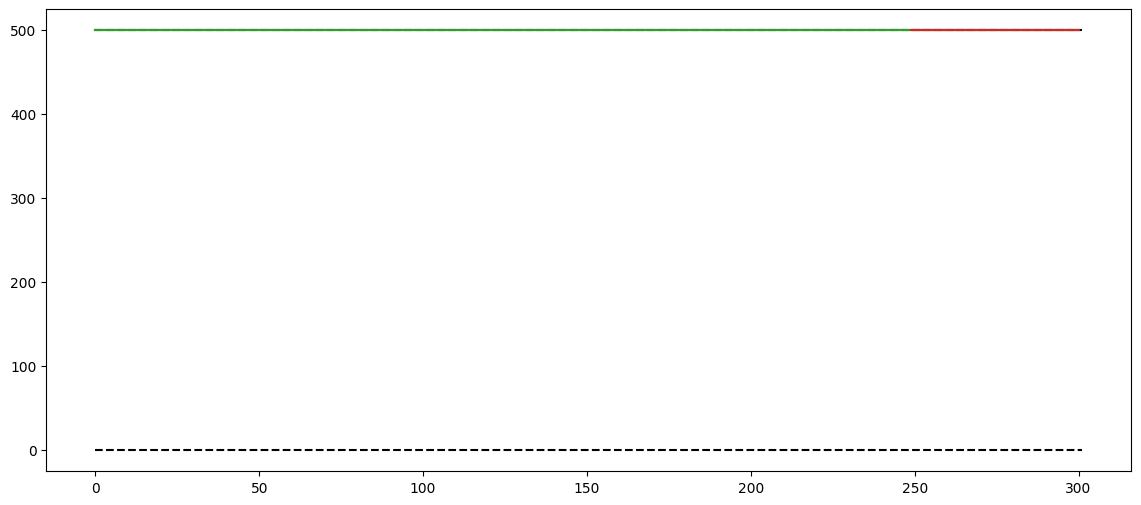

In [93]:
test_rewards = run_agent_in_env(env, agent, 400, learning=False, plot=True, plot_interval=100)
print(f"Reward: {np.mean(test_rewards):.2f}")